# Capstone Project - Clustering neighbourhoods in Madrid, Spain
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Exploratory Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

---------------------------------------

#### Import of Libraries

In [1]:
!pip install lxml  # HTML parser for compatible with BS4
#!pip install html5lib  # HTML parser for compatible with BS4

     |████████████████████████████████| 5.8MB 5.0MB/s eta 0:00:01     |███                             | 532kB 5.0MB/s eta 0:00:02     |██████▏                         | 1.1MB 5.0MB/s eta 0:00:01


ATTENTION! Now, please: restart the Kernel

In [1]:
!pip install bs4   # Install BeautifulSoup 4

!pip install openpyxl  # To export data to excel
!pip install geocoder
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install webcolors   # To help understand in the map which color is which cluster...
#!conda install -c conda-forge geopy --yes 

# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

     |████████████████████████████████| 112kB 6.2MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 174kB 24.7MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/b5/85/ca/e768ac132e57e75e645a151f8badac71cc0089e7225dddf76b
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/2a/77/35/0da0965a057698121fc7d8c5a7a9955cdbfb3cc4e2423cad39
Successfully built openpyxl et-xmlfile
     |████████████████████████████████| 102kB 19.5MB/s ta 0:00:01
     |████████████████████████████████| 92kB 6.7MB/s  eta 0:00:01
     |████████████████████████████████| 829kB 25.8MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: do

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

from bs4 import BeautifulSoup
import lxml
#import html5lib

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

import geocoder # import geocoder
from io import StringIO

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium # map rendering library

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import webcolors

# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

import seaborn as sns

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS
#print ('Wordcloud is installed and imported!')

from PIL import Image # converting images into arrays

# import k-means from clustering stage
from sklearn.cluster import KMeans

print("\nLibraries imported.")

Matplotlib version:  3.1.1

Libraries imported.


-----------------------------------------

# 1. Introduction: Business Problem <a name="introduction"></a>

The objective of the project is to **characterize the city neighborhoods of Madrid, Spain**, so that we can **give hints to help people choose the best place to live** in Madrid.

Madrid is a big city that welcomes everyone. It has every infrastructure you may need: health, education, arts, sports... **We will use the power of data science to go a step further** and help explain Madrid's neighborhoods based on different clustering criteria.

The characterization will be mainly based on:

* The number and kind of venues in 500 meters around the center of the neighborhood
* People density and surface of the neighborhood

With this information, **we will be able to suggest a list of neighborhoods that have:**

* Lots of **entertainment** venues around, especially suitable for young couples
* **Parks and places to have a walk**, maybe preferable for families with children or people who likes sports and/or nature
* **Museums, landscaping venues, etc.** could apply for different kinds people
* Or even neighborhoods with **no venues at all**, for people that is looking for **quiet residential neighborhoods**

The **intended audience is anyone who wants to live in Madrid, Spain, and doesn't know where to start looking for** a house. Having a first characterization of each neighborhood will help them start making their choice. It will be interesting for them as it will help them to ‘break the ice’.

----------------------------------------

# 2. Data <a name="data"></a>

Based on the definition of the problem, we will be using mainly the following sources:
* **Wikipedia**: for a full list of districts and neighbourhoods in the city of Madrid, Spain. <br>
    District information comes with: 'District name', 'Total surface (Ha2, Km2)', 'population', 'density of population', 'image' and 'list of neighbourhoods'.<br>https://es.wikipedia.org/wiki/Anexo:Distritos_de_Madrid

<table class="Districts">
      <tr>  <th align="center">Number</th><th align="center">Name</th><th align="center">Surface (Ha)</th><th align="center">Population</th><th align="center">Density of Population (Pop/Ha)</th><th align="center">Image</th><th align="center">List of Neighbourhoods</th>  </TR>
      <tr>  <td align="center">1</td><td align="center">Center</td><td align="center">522,82</td><td align="center">131 928</td><td align="center">252,34</td><td align="center"><img alt="Centro District loc-map.svg" data-file-height="527" data-file-width="527" decoding="async" height="200" src="//upload.wikimedia.org/wikipedia/commons/thumb/0/09/Centro_District_loc-map.svg/200px-Centro_District_loc-map.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/0/09/Centro_District_loc-map.svg/300px-Centro_District_loc-map.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/0/09/Centro_District_loc-map.svg/400px-Centro_District_loc-map.svg.png 2x" width="200"/></td><td align="center">Palacio (11)<br>Embajadores (12)<BR>Cortes(13)<BR>Justicia(14)<BR>Universidad(15)<BR>Sol(16)</td>  </TR>
      <tr>  <td align="center">2</td><td align="center">Arganzuela</td><td align="center">646,22</td><td align="center">151 965</td><td align="center">235,16</td><td align="center"><img alt="Arganzuela District loc-map.svg" data-file-height="527" data-file-width="527" decoding="async" height="200" src="//upload.wikimedia.org/wikipedia/commons/thumb/6/66/Arganzuela_District_loc-map.svg/200px-Arganzuela_District_loc-map.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/6/66/Arganzuela_District_loc-map.svg/300px-Arganzuela_District_loc-map.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/6/66/Arganzuela_District_loc-map.svg/400px-Arganzuela_District_loc-map.svg.png 2x" width="200"/></td><td align="center">Imperial (21)<br>Acacias (22)<BR>Chopera(23)<BR>Justicia(14)<BR>Universidad(15)<BR>Sol(16)</td>  </TR>
    </table>
                    
* **FourSquare API**: to take the number and type of venues in each neighbourhood of Madrid... **Coffee Shops, Pharmacies, Home Service, etc.** Each venue comes with locatization, name of venue and lots of tips (even client remarks)
          
* **OpenStreetMap API (Nominatim)**. We will use ‘OpenStreetMap’ to find the latitude and longitude of each neighborhood, based on its name. We need the geo-localization of the neighborhoods to serve as input for ‘FourSquare’ services<BR>
For example: the coordinates for Madrid are **40.4893538** (Latitud) and **-3.6827461** (Longitud)


Additional information, if needed, could be taken from other:
* The city council 'data bank': https://datos.madrid.es/
* or from the National Statistic Institute of Spain (https://www.ine.es/)


## DATA EXPLORATION: List of districts in Madrid, Spain
Source: Wikipedia, https://es.wikipedia.org/wiki/Anexo:Distritos_de_Madrid<BR>
We are looking for the list of Districts and Neighbourhoods with the associated KPIs: surface, population and density of population

In [122]:
# We download the wikipedia webpage
url = "https://es.wikipedia.org/wiki/Anexo:Distritos_de_Madrid"
website_url = requests.get(url).text

soup = BeautifulSoup(website_url,features='lxml')
#print(soup.prettify())  # It shows in an understandable way the HTML code for the page

In [123]:
# The table is the first 'wikitable sortable' table
My_table = soup.find('table',{'class':'wikitable sortable'})  # Select first objetc of that kind
#My_table = soup.find_all('table')[0] # Grab the first table
#My_table

In [4]:
# We take the data into a new dataframe

# We define the DataFrame columns
column_names = ['District Code', 'District', 'District Surface', 'District Population', 'District density', 'Neighborhood'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# Populate the dataFrame with the Toronto neighbourhoods
for row in My_table.find_all('tr'):     # <tr> is the line id, in an HTML table
    columns = row.find_all('td')        # <td> is the Column id, inside a row of an HTML table
    
    # For each line in the table (except for the title row)
    if (len(row.find_all('td')) != 0):  # skip title row: which doesn't have <td> tags, just <th> ones
        
        # Select the data (removing spaces and \n at the end of the data)
        district_code = columns[0].get_text().rstrip()
        district = columns[1].get_text().rstrip()
        surface = float(columns[2].find_all('span')[0].get_text().strip('& ').replace('&', '0'))
        population = float(columns[3].find_all('span')[0].get_text().strip('& ').replace('&', '0'))
        density = float(columns[4].find_all('span')[0].get_text().strip('& ').replace('&', '0'))
        #list_of_neighbourhodds = columns[6].get_text().rstrip()
        
        # extraigo la lista de barrios
        for aref in columns[6].find_all('a'):     # <tr> is the line id, in an HTML table
            neighborhood = aref.get_text()
            
            # Two specific cases with the names:
            if neighborhood == "Guindalera": neighborhood = "La Guindalera"
            if neighborhood == "Pilar": neighborhood = "El Pilar"
                          
            neighborhoods = neighborhoods.append({'District Code': district_code,
                                              'District': district,
                                              'District Population': population,
                                              'District Surface': surface,
                                              'District density': density,
                                              'Neighborhood': neighborhood
                                             }, ignore_index=True)

# Now we clean the numbers
#data['result'] = data['result'].map(lambda x: x.lstrip('+-').rstrip('aAbBcC'))
            
print(neighborhoods.shape)
neighborhoods.head()

(131, 6)


District Code District  District Surface  District Population  \
0             1   Centro            522.82             131928.0   
1             1   Centro            522.82             131928.0   
2             1   Centro            522.82             131928.0   
3             1   Centro            522.82             131928.0   
4             1   Centro            522.82             131928.0   

   District density Neighborhood  
0            252.34      Palacio  
1            252.34  Embajadores  
2            252.34       Cortes  
3            252.34     Justicia  
4            252.34  Universidad

## DATA EXPLORATION: Append 'Neighbourhood' ID and surface to the DataFrame
Source: Wikipedia, https://es.wikipedia.org/wiki/Anexo:Barrios_administrativos_de_Madrid

In [124]:
# We download the wikipedia webpage
url = "https://es.wikipedia.org/wiki/Anexo:Barrios_administrativos_de_Madrid"
website_url = requests.get(url).text

soup = BeautifulSoup(website_url,features='lxml')
#print(soup.prettify())  # It shows in an understandable way the HTML code for the page

In [125]:
# The table is the first 'wikitable sortable' table
My_table = soup.find('table',{'class':'wikitable sortable'})  # Select first objetc of that kind
#My_table = soup.find_all('table')[0] # Grab the first table
#My_table

In [7]:
# We take the data into a new dataframe: ID, Neighborhood and Surfac

# We define the DataFrame columns
column_names = ['Neighborhood Code', 'Neighborhood Surface', 'Neighborhood'] 

# instantiate the dataframe
neighborhoods2 = pd.DataFrame(columns=column_names)

# Populate the dataFrame with the Toronto neighbourhoods
for row in My_table.find_all('tr'):     # <tr> is the line id, in an HTML table
    columns = row.find_all('td')        # <td> is the Column id, inside a row of an HTML table
    number_rows = len(columns)          # Number of <td> cells in the line
    
    # For each line in the table (except for the title row)
    if number_rows != 0:  # skip title row: which doesn't have <td> tags, just <th> ones
        
        offset = 0
        if number_rows == 5:
            offset = 1
        
        # Select the data (removing spaces and \n at the end of the data)
        neighborhood_code = columns[0 + offset].get_text().rstrip()
        surface = columns[2 + offset].get_text().strip(' km² \n').replace(',','.')
        neighborhood = columns[1 + offset].get_text().rstrip()
        
        # 3 specific neighbourhoods that lack a precise surface:
        if neighborhood_code == "183": surface = "1.944"
        if neighborhood_code == "193": surface = "0.549"
        if neighborhood_code == "194": surface = "9.388"
        surface = float(surface)
        
        neighborhoods2 = neighborhoods2.append({'Neighborhood Code': neighborhood_code,
                                              'Neighborhood Surface': surface,
                                              'Neighborhood': neighborhood
                                             }, ignore_index=True)
            

#neighborhoods2['Neighborhood Surface'] = neighborhoods2['Neighborhood Surface'].astype(float)
print(neighborhoods2.shape)
neighborhoods2.head()

(131, 3)


Neighborhood Code  Neighborhood Surface Neighborhood
0                11                 1.471      Palacio
1                12                 1.032  Embajadores
2                13                 0.592       Cortes
3                14                 0.742     Justicia
4                15                 0.947  Universidad

#### Now we merge the new data with the Neighbourhoods DataFrame

In [8]:
neighborhoods = pd.merge(neighborhoods, neighborhoods2, left_on='Neighborhood', right_on='Neighborhood')
print(neighborhoods.shape)
neighborhoods.head(10)

(131, 8)


District Code    District  District Surface  District Population  \
0             1      Centro            522.82             131928.0   
1             1      Centro            522.82             131928.0   
2             1      Centro            522.82             131928.0   
3             1      Centro            522.82             131928.0   
4             1      Centro            522.82             131928.0   
5             1      Centro            522.82             131928.0   
6             2  Arganzuela            646.22             151965.0   
7             2  Arganzuela            646.22             151965.0   
8             2  Arganzuela            646.22             151965.0   
9             2  Arganzuela            646.22             151965.0   

   District density Neighborhood Neighborhood Code  Neighborhood Surface  
0            252.34      Palacio                11                 1.471  
1            252.34  Embajadores                12                 1.032  
2            252.34       Cortes                13                 0.592  
3            252.34     Justicia                14                 0.742  
4            252.34  Universidad                15                 0.947  
5            252.34          Sol                16                 0.445  
6            235.16     Imperial                21                 0.967  
7            235.16      Acacias                22                 1.074  
8            235.16      Chopera                23                 0.566  
9            235.16      Legazpi                24                 1.396

## DATA EXPLORATION: Identifying coordinates (latitude, longitude)

Here, we declare a 'geolocator' object, and create a new DataFrame to store the coordinates of each Neighbourhood

In [11]:
# Create a geolocator object
geolocator = Nominatim(user_agent='madrid_agent')

# define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
coordinates = pd.DataFrame(columns=column_names)

In [12]:
# Define a function to look for coordinates of each neighbourhood
def get_coordinates(address):
    #address = neighborhoods.loc[0, 'Neighborhood'] + ", Madrid, Spain"
    address = address + ", Madrid, Spain"
    latitude = None
    longitude = None
    
    location = geolocator.geocode(address)
    if location != None :
        latitude = location.latitude
        longitude = location.longitude
    #print(latitude, longitude)

    return latitude, longitude

In [11]:
# Include Latitude and Longitude of each Neighbourhood
for index, row in neighborhoods.iterrows():
    address = row['Neighborhood']
    latitude, longitude = get_coordinates(address)
    
    print(index, row[1], address, latitude, longitude)
    coordinates = coordinates.append({
        'Neighborhood': address,
        'Latitude': latitude,
        'Longitude': longitude
    }, ignore_index=True)

0 Centro Palacio 40.41512925 -3.7156179983990922
1 Centro Embajadores 40.409680550000004 -3.701644426413222
2 Centro Cortes 40.4147791 -3.6975842
3 Centro Justicia 40.42395689999999 -3.6957473208550464
4 Centro Universidad 40.4254085 -3.7059885
5 Centro Sol 40.4178272 -3.702222089915074
6 Arganzuela Imperial 40.4057995 -3.7186854
7 Arganzuela Acacias 40.4040749 -3.7059572
8 Arganzuela Chopera 40.39489315 -3.6997051134630077
9 Arganzuela Legazpi 40.3911717 -3.6951902
10 Arganzuela Delicias 40.39729215 -3.6894948496947286
11 Arganzuela Palos de Moguer 40.403926850000005 -3.6955613279574164
12 Arganzuela Atocha 40.4052036 -3.6879295943334167
13 Retiro Pacífico 40.4013961 -3.6748832
14 Retiro Adelfas 40.40027955 -3.6717736378097605
15 Retiro Estrella 40.41441435 -3.6652178934436255
16 Retiro Ibiza 40.4189526 -3.6737251
17 Retiro Jerónimos 40.4137286 -3.6853564354967547
18 Retiro Niño Jesús 40.413441399999996 -3.6733367908983414
19 Salamanca Recoletos 40.42417315 -3.685487264974136
20 Salam

In [13]:
latitude, longitude = get_coordinates('Madrid')
print('Coordinates of Madrid are: {} latitude, {} longitude'.format(latitude, longitude))

Coordinates of Madrid are: 40.4167047 latitude, -3.7035825 longitude


In [13]:
# We include manually three coordinates not resolved by geolocator:
# Source: https://www.comollegara.com/direccion-a-lat-long.html?lugar=calle%20minerva%20madrid%20drid
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Los Cármenes', 'Latitude'] = 40.4663
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Los Cármenes', 'Longitude'] = -3.68341
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Valderrivas', 'Latitude'] = 40.3993
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Valderrivas', 'Longitude'] = -3.602
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Casco Histórico de Barajas', 'Latitude'] = 40.470279
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Casco Histórico de Barajas', 'Longitude'] = -3.5850

# We correct manually some coordinates bad resolved by geolocator:
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'La Guindalera', 'Latitude'] = 40.4324
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'La Guindalera', 'Longitude'] = -3.665999
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Castillejos', 'Latitude'] = 40.45647
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Castillejos', 'Longitude'] = -3.69614
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'El Plantío', 'Latitude'] = 40.472881317
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'El Plantío', 'Longitude'] = -3.827379942
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'San Isidro', 'Latitude'] = 40.40503
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'San Isidro', 'Longitude'] = -3.72475
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Buenavista', 'Latitude'] = 40.368598938
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Buenavista', 'Longitude'] = -3.740050077
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Timón', 'Latitude'] = 40.485679626
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Timón', 'Longitude'] = -3.604720116
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Corralejos', 'Latitude'] = 40.465400696
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Corralejos', 'Longitude'] = -3.611639977

coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Aeropuerto', 'Latitude'] = 40.45182
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Aeropuerto', 'Longitude'] = -3.58374
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Casco Histórico de Vallecas', 'Latitude'] = 40.382999420
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Casco Histórico de Vallecas', 'Longitude'] = -3.617000103
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Casco Histórico de Vicálvaro', 'Latitude'] = 40.404201508
coordinates.loc[coordinates.loc[:, 'Neighborhood'] == 'Casco Histórico de Vicálvaro', 'Longitude'] = -3.608059883



In [14]:
print(coordinates.shape)
coordinates.head(5)

(131, 3)


Neighborhood   Latitude  Longitude
0      Palacio  40.415129  -3.715618
1  Embajadores  40.409681  -3.701644
2       Cortes  40.414779  -3.697584
3     Justicia  40.423957  -3.695747
4  Universidad  40.425409  -3.705989

Now we merge our new info into neighborhoods DataFrame

In [15]:
neighborhoods = pd.merge(neighborhoods, coordinates, left_on='Neighborhood', right_on='Neighborhood')
print("shape: ", neighborhoods.shape)
neighborhoods.head(10)

shape:  (131, 10)


District Code    District  District Surface  District Population  \
0             1      Centro            522.82             131928.0   
1             1      Centro            522.82             131928.0   
2             1      Centro            522.82             131928.0   
3             1      Centro            522.82             131928.0   
4             1      Centro            522.82             131928.0   
5             1      Centro            522.82             131928.0   
6             2  Arganzuela            646.22             151965.0   
7             2  Arganzuela            646.22             151965.0   
8             2  Arganzuela            646.22             151965.0   
9             2  Arganzuela            646.22             151965.0   

   District density Neighborhood Neighborhood Code  Neighborhood Surface  \
0            252.34      Palacio                11                 1.471   
1            252.34  Embajadores                12                 1.032   
2            252.34       Cortes                13                 0.592   
3            252.34     Justicia                14                 0.742   
4            252.34  Universidad                15                 0.947   
5            252.34          Sol                16                 0.445   
6            235.16     Imperial                21                 0.967   
7            235.16      Acacias                22                 1.074   
8            235.16      Chopera                23                 0.566   
9            235.16      Legazpi                24                 1.396   

    Latitude  Longitude  
0  40.415129  -3.715618  
1  40.409681  -3.701644  
2  40.414779  -3.697584  
3  40.423957  -3.695747  
4  40.425409  -3.705989  
5  40.417827  -3.702222  
6  40.405800  -3.718685  
7  40.404075  -3.705957  
8  40.394893  -3.699705  
9  40.391172  -3.695190

**ATTENTION!** Here, we save a copy and recover the DataFrame up to now, to avoid re-starting everytime as I am building the final DataFrame

In [16]:
neighborhoods.to_csv('madrid_neighborhoods.csv')

In [17]:
# Execute always you need to reload FourSquare data
neighborhoods = pd.read_csv('madrid_neighborhoods.csv')
neighborhoods.drop('Unnamed: 0', axis=1, inplace=True)
print(neighborhoods.shape)
neighborhoods.head()

(131, 10)


District Code District  District Surface  District Population  \
0              1   Centro            522.82             131928.0   
1              1   Centro            522.82             131928.0   
2              1   Centro            522.82             131928.0   
3              1   Centro            522.82             131928.0   
4              1   Centro            522.82             131928.0   

   District density Neighborhood  Neighborhood Code  Neighborhood Surface  \
0            252.34      Palacio                 11                 1.471   
1            252.34  Embajadores                 12                 1.032   
2            252.34       Cortes                 13                 0.592   
3            252.34     Justicia                 14                 0.742   
4            252.34  Universidad                 15                 0.947   

    Latitude  Longitude  
0  40.415129  -3.715618  
1  40.409681  -3.701644  
2  40.414779  -3.697584  
3  40.423957  -3.695747  
4  40.425409  -3.705989

## DATA EXPLORATION: Getting the venues of each neighbourhood from FOURSQUARE

#### Define Foursquare credentials and version
Below are the credentials for FourSquare (hopefully hidden)

In [18]:
# @hidden_cell
CLIENT_ID = 'ILFGWMEPJLUOTF4P01CJPWEJ4HTCQQU51MRGVI4B0BSEELEZ' # your Foursquare ID
CLIENT_SECRET = 'yAY0CTHXLR5TR2EATVBX1S3PAHOYL1SHN5WA1XPFUNHTT1BZQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100
ACCESS_TOKEN = '5KMXQWXZI3RGOI5S3LAAZWYF1QL5UTBAYQ1GVQUE3O10W1RV'    # Authentication Token: see instructions in Coursera

# print('Your credentails:')
# print('CLIENT_ID: ' + CLIENT_ID)
# print('CLIENT_SECRET:' + CLIENT_SECRET)

#### Let's use the function defined in 'New York clustering' to get the venues information from all the neighborhoods in Toronto
The function is based on the coordinates to look for the venues, the 'Neighborhood' is only a reference to recover the info from the dataset (we will use 'Postal_Code'+'Neighborhood' to avoide missuse of information.

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    count = 1
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(count, name)
        count = count + 1
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&oauth_token={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            ACCESS_TOKEN
        )
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### We create a new DataFrame with Toronto's venues by neighborhood
ATTENTION! Don't execute the following cell if you already have the information in the csv file (to avoid overcome the daily cap of questions in FourSquare)

In [20]:
madrid_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                 latitudes=neighborhoods['Latitude'],
                                 longitudes=neighborhoods['Longitude']
                                )

1 Palacio
2 Embajadores
3 Cortes
4 Justicia
5 Universidad
6 Sol
7 Imperial
8 Acacias
9 Chopera
10 Legazpi
11 Delicias
12 Palos de Moguer
13 Atocha
14 Pacífico
15 Adelfas
16 Estrella
17 Ibiza
18 Jerónimos
19 Niño Jesús
20 Recoletos
21 Goya
22 Fuente del Berro
23 La Guindalera
24 Lista
25 Castellana
26 El Viso
27 Prosperidad
28 Ciudad Jardín
29 Hispanoamérica
30 Nueva España
31 Castilla
32 Bellas Vistas
33 Cuatro Caminos
34 Castillejos
35 Almenara
36 Valdeacederas
37 Berruguete
38 Gaztambide
39 Arapiles
40 Trafalgar
41 Almagro
42 Ríos Rosas
43 Vallehermoso
44 El Pardo
45 Fuentelarreina
46 Peñagrande
47 El Pilar
48 La Paz
49 Valverde
50 Mirasierra
51 El Goloso
52 Casa de Campo
53 Argüelles
54 Ciudad Universitaria
55 Valdezarza
56 Valdemarín
57 El Plantío
58 Aravaca
59 Los Cármenes
60 Puerta del Ángel
61 Lucero
62 Aluche
63 Campamento
64 Cuatro Vientos
65 Las Águilas
66 Comillas
67 Opañel
68 San Isidro
69 Vista Alegre
70 Puerta Bonita
71 Buenavista
72 Abrantes
73 Orcasitas
74 Orcasur
75 Sa

In [21]:
print(madrid_venues.shape)
madrid_venues.head()

(4219, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0      Palacio              40.415129               -3.715618   
1      Palacio              40.415129               -3.715618   
2      Palacio              40.415129               -3.715618   
3      Palacio              40.415129               -3.715618   
4      Palacio              40.415129               -3.715618   

                                             Venue  Venue Latitude  \
0     Almudena Cathedral (Catedral de la Almudena)       40.415767   
1                             Plaza de La Almudena       40.416320   
2                              Cervecería La Mayor       40.415218   
3                                  Taberna Rayuela       40.413179   
4  Royal Palace of Madrid (Palacio Real de Madrid)       40.417940   

   Venue Longitude    Venue Category  
0        -3.714516            Church  
1        -3.713777             Plaza  
2        -3.712194          Beer Bar  
3        -3.713496  Tapas Restaurant  
4        -3.714259            Palace

#### Now, we save the venues to a 'csv' file to avoid over-using the daily FourSquare service
ATTENTION! Execute this to get a csv copy of the FourSquare information

In [22]:
# Execute always after reading from FourSquare, to save the data
madrid_venues.to_csv('madrid_venues.csv')

#### We can reload the venues from the csv file instead of asking again to FourSquare if we need to refresh the DataFrame
ATTENTION! You can continue here...

In [23]:
# Execute always you need to reload FourSquare data
madrid_venues = pd.read_csv('madrid_venues.csv')
madrid_venues.drop('Unnamed: 0', axis=1, inplace=True)
print(madrid_venues.shape)
madrid_venues.head()

(4219, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0      Palacio              40.415129               -3.715618   
1      Palacio              40.415129               -3.715618   
2      Palacio              40.415129               -3.715618   
3      Palacio              40.415129               -3.715618   
4      Palacio              40.415129               -3.715618   

                                             Venue  Venue Latitude  \
0     Almudena Cathedral (Catedral de la Almudena)       40.415767   
1                             Plaza de La Almudena       40.416320   
2                              Cervecería La Mayor       40.415218   
3                                  Taberna Rayuela       40.413179   
4  Royal Palace of Madrid (Palacio Real de Madrid)       40.417940   

   Venue Longitude    Venue Category  
0        -3.714516            Church  
1        -3.713777             Plaza  
2        -3.712194          Beer Bar  
3        -3.713496  Tapas Restaurant  
4        -3.714259            Palace

Let's find out how many unique categories can be curated from all the returned venues

In [24]:
print('There are {} unique venue categories.'.format(len(madrid_venues['Venue Category'].unique())))

There are 304 unique venue categories.


## DATA EXPLORATION: We write down 'how many' venues are in each neighborhood

In [25]:
# We calculate the number of venues by Neighbourhood
madrid_number_venues = madrid_venues.groupby('Neighborhood', as_index=False, sort=False).count()

# We clean the columns before merging:
madrid_number_venues.rename(columns={'Neighborhood Latitude':'Number Venues'}, inplace=True)    # Rename first column
madrid_number_venues.drop(['Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], axis=1, inplace=True)  # Remove un-needed columns

madrid_number_venues.head()

Neighborhood  Number Venues
0      Palacio             68
1  Embajadores            100
2       Cortes            100
3     Justicia            100
4  Universidad            100

#### We now merge '#Venues' with the neighbourhood dataframe
We include:
* Number of venues by neighborhood
* Percentage of venues in the neighborhood o/ total venues in the city (value between 0 and 1)

In [26]:
# merge, to include #venues registered
neighborhoods = pd.merge(neighborhoods, madrid_number_venues, left_on='Neighborhood', right_on='Neighborhood', how='left')   # Left join

# Where there is no venue, we write zero (0)
neighborhoods['Number Venues'].replace(np.nan, '0', inplace=True)
neighborhoods['Number Venues'] = neighborhoods['Number Venues'].astype(float)
neighborhoods['Percentage Venues'] = neighborhoods['Number Venues']/ neighborhoods['Number Venues'].sum()

neighborhoods.head(10)

District Code    District  District Surface  District Population  \
0              1      Centro            522.82             131928.0   
1              1      Centro            522.82             131928.0   
2              1      Centro            522.82             131928.0   
3              1      Centro            522.82             131928.0   
4              1      Centro            522.82             131928.0   
5              1      Centro            522.82             131928.0   
6              2  Arganzuela            646.22             151965.0   
7              2  Arganzuela            646.22             151965.0   
8              2  Arganzuela            646.22             151965.0   
9              2  Arganzuela            646.22             151965.0   

   District density Neighborhood  Neighborhood Code  Neighborhood Surface  \
0            252.34      Palacio                 11                 1.471   
1            252.34  Embajadores                 12                 1.032   
2            252.34       Cortes                 13                 0.592   
3            252.34     Justicia                 14                 0.742   
4            252.34  Universidad                 15                 0.947   
5            252.34          Sol                 16                 0.445   
6            235.16     Imperial                 21                 0.967   
7            235.16      Acacias                 22                 1.074   
8            235.16      Chopera                 23                 0.566   
9            235.16      Legazpi                 24                 1.396   

    Latitude  Longitude  Number Venues  Percentage Venues  
0  40.415129  -3.715618           68.0           0.016118  
1  40.409681  -3.701644          100.0           0.023702  
2  40.414779  -3.697584          100.0           0.023702  
3  40.423957  -3.695747          100.0           0.023702  
4  40.425409  -3.705989          100.0           0.023702  
5  40.417827  -3.702222          100.0           0.023702  
6  40.405800  -3.718685           38.0           0.009007  
7  40.404075  -3.705957           45.0           0.010666  
8  40.394893  -3.699705           32.0           0.007585  
9  40.391172  -3.695190           25.0           0.005926

## DATA EXPLORATION: We prepare a table to train clusterization models based on 'top 10 venues by neighborhood'

#### One hot coding of the venues by neighbourhood

In [27]:
# one hot encoding
madrid_onehot = pd.get_dummies(madrid_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
madrid_onehot['Neighborhood'] = madrid_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = list(madrid_onehot.columns)
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
madrid_onehot = madrid_onehot[fixed_columns]

print(madrid_onehot.shape)
madrid_onehot.head()

(4219, 304)


Neighborhood  ATM  Accessories Store  Adult Boutique  Advertising Agency  \
0      Palacio    0                  0               0                   0   
1      Palacio    0                  0               0                   0   
2      Palacio    0                  0               0                   0   
3      Palacio    0                  0               0                   0   
4      Palacio    0                  0               0                   0   

   Airport  American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
0        0                    0                 0                       0   
1        0                    0                 0                       0   
2        0                    0                 0                       0   
3        0                    0                 0                       0   
4        0                    0                 0                       0   

   Art Gallery  Art Museum  Art Studio  Arts & Crafts Store  Asian Restaurant  \
0            0           0           0                    0                 0   
1            0           0           0                    0                 0   
2            0           0           0                    0                 0   
3            0           0           0                    0                 0   
4            0           0           0                    0                 0   

   Astrologer  Athletics & Sports  Auto Dealership  Auto Garage  BBQ Joint  \
0           0                   0                0            0          0   
1           0                   0                0            0          0   
2           0                   0                0            0          0   
3           0                   0                0            0          0   
4           0                   0                0            0          0   

   Baby Store  Bagel Shop  Bakery  Bank  Bar  Basketball Court  \
0           0           0       0     0    0                 0   
1           0           0       0     0    0                 0   
2           0           0       0     0    0                 0   
3           0           0       0     0    0                 0   
4           0           0       0     0    0                 0   

   Basketball Stadium  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0                   0                0         0            0           0   
1                   0                0         0            0           0   
2                   0                0         1            0           0   
3                   0                0         0            0           0   
4                   0                0         0            0           0   

   Big Box Store  Bistro  Board Shop  Boat or Ferry  Bookstore  Boutique  \
0              0       0           0              0          0         0   
1              0       0           0              0          0         0   
2              0       0           0              0          0         0   
3              0       0           0              0          0         0   
4              0       0           0              0          0         0   

   Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  \
0              0           0                     0               0        0   
1              0           0                     0               0        0   
2              0           0                     0               0        0   
3              0           0                     0               0        0   
4              0           0                     0               0        0   

   Buffet  Building  Burger Joint  Burrito Place  Bus Line  Bus Station  \
0       0         0             0              0         0            0   
1       0         0             0              0         0            0   
2       0         0             0              0         0            0   
3       0         0   

In [28]:
madrid_grouped = madrid_onehot.groupby('Neighborhood').mean().reset_index()
print(madrid_grouped.shape)
madrid_grouped.head()

(131, 304)


Neighborhood  ATM  Accessories Store  Adult Boutique  \
0          Abrantes  0.0                0.0             0.0   
1           Acacias  0.0                0.0             0.0   
2           Adelfas  0.0                0.0             0.0   
3        Aeropuerto  0.0                0.0             0.0   
4  Alameda de Osuna  0.0                0.0             0.0   

   Advertising Agency  Airport  American Restaurant  Arepa Restaurant  \
0                 0.0      0.0                  0.0               0.0   
1                 0.0      0.0                  0.0               0.0   
2                 0.0      0.0                  0.0               0.0   
3                 0.0      0.0                  0.0               0.0   
4                 0.0      0.0                  0.0               0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Art Studio  \
0                     0.0     0.000000         0.0         0.0   
1                     0.0     0.066667         0.0         0.0   
2                     0.0     0.000000         0.0         0.0   
3                     0.0     0.000000         0.0         0.0   
4                     0.0     0.000000         0.0         0.0   

   Arts & Crafts Store  Asian Restaurant  Astrologer  Athletics & Sports  \
0                  0.0          0.000000    0.058824            0.058824   
1                  0.0          0.022222    0.000000            0.000000   
2                  0.0          0.020408    0.000000            0.000000   
3                  0.0          0.000000    0.000000            0.000000   
4                  0.0          0.000000    0.000000            0.000000   

   Auto Dealership  Auto Garage  BBQ Joint  Baby Store  Bagel Shop    Bakery  \
0              0.0          0.0        0.0         0.0         0.0  0.117647   
1              0.0          0.0        0.0         0.0         0.0  0.022222   
2              0.0          0.0        0.0         0.0         0.0  0.020408   
3              0.0          0.0        0.0         0.0         0.0  0.000000   
4              0.0          0.0        0.0         0.0         0.0  0.064516   

   Bank       Bar  Basketball Court  Basketball Stadium  Bed & Breakfast  \
0   0.0  0.000000               0.0                 0.0              0.0   
1   0.0  0.111111               0.0                 0.0              0.0   
2   0.0  0.061224               0.0                 0.0              0.0   
3   0.0  0.000000               0.0                 0.0              0.0   
4   0.0  0.032258               0.0                 0.0              0.0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bistro  Board Shop  \
0       0.0          0.0         0.0            0.0     0.0         0.0   
1       0.0          0.0         0.0            0.0     0.0         0.0   
2       0.0          0.0         0.0            0.0     0.0         0.0   
3       0.0          0.0         0.0            0.0     0.0         0.0   
4       0.0          0.0         0.0            0.0     0.0         0.0   

   Boat or Ferry  Bookstore  Boutique  Bowling Alley  Boxing Gym  \
0            0.0   0.000000       0.0            0.0         0.0   
1            0.0   0.066667       0.0            0.0         0.0   
2            0.0   0.020408       0.0            0.0         0.0   
3            0.0   0.000000       0.0            0.0         0.0   
4            0.0   0.032258       0.0            0.0         0.0   

   Brazilian Restaurant  Breakfast Spot   Brewery  Buffet  Building  \
0                   0.0        0.000000  0.000000     0.0       0.0   
1                   0.0        0.000000  0.000000     0.0       0.0   
2                   0.0        0.020408  0.020408     0.0       0.0   
3                   0.0        0.043478  0.000000     0.0       0.0   
4                   0.0        0.032258  0.000000     0.0       0.0   

   Burger Joint  Burrito Place  Bus Line  Bus Station  Bus Stop  \
0           0.0            0.0       0.0   

As we already knew: there are 131 - 122 = 9 neighborhoods that doesn't have any venue in 500 meters around the coordinates. 

We merge that information with the Neighborhood dataframe.

In [29]:
neighborhoods = pd.merge(neighborhoods, madrid_grouped, left_on='Neighborhood', right_on='Neighborhood', how='left')

# Where there is no venue, we write zero (0)
neighborhoods.replace(np.nan, '0', inplace=True)

print(neighborhoods.shape)
neighborhoods.head()

(131, 315)


District Code District  District Surface  District Population  \
0              1   Centro            522.82             131928.0   
1              1   Centro            522.82             131928.0   
2              1   Centro            522.82             131928.0   
3              1   Centro            522.82             131928.0   
4              1   Centro            522.82             131928.0   

   District density Neighborhood  Neighborhood Code  Neighborhood Surface  \
0            252.34      Palacio                 11                 1.471   
1            252.34  Embajadores                 12                 1.032   
2            252.34       Cortes                 13                 0.592   
3            252.34     Justicia                 14                 0.742   
4            252.34  Universidad                 15                 0.947   

    Latitude  Longitude  Number Venues  Percentage Venues  ATM  \
0  40.415129  -3.715618           68.0           0.016118  0.0   
1  40.409681  -3.701644          100.0           0.023702  0.0   
2  40.414779  -3.697584          100.0           0.023702  0.0   
3  40.423957  -3.695747          100.0           0.023702  0.0   
4  40.425409  -3.705989          100.0           0.023702  0.0   

   Accessories Store  Adult Boutique  Advertising Agency  Airport  \
0               0.00            0.00                 0.0      0.0   
1               0.00            0.00                 0.0      0.0   
2               0.00            0.00                 0.0      0.0   
3               0.01            0.01                 0.0      0.0   
4               0.00            0.00                 0.0      0.0   

   American Restaurant  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0                 0.00               0.0                0.014706         0.00   
1                 0.00               0.0                0.010000         0.03   
2                 0.00               0.0                0.010000         0.01   
3                 0.03               0.0                0.010000         0.01   
4                 0.00               0.0                0.020000         0.01   

   Art Museum  Art Studio  Arts & Crafts Store  Asian Restaurant  Astrologer  \
0        0.00         0.0                 0.00              0.00         0.0   
1        0.00         0.0                 0.00              0.00         0.0   
2        0.01         0.0                 0.00              0.01         0.0   
3        0.01         0.0                 0.01              0.00         0.0   
4        0.00         0.0                 0.01              0.00         0.0   

   Athletics & Sports  Auto Dealership  Auto Garage  BBQ Joint  Baby Store  \
0                 0.0              0.0          0.0       0.00         0.0   
1                 0.0              0.0          0.0       0.00         0.0   
2                 0.0              0.0          0.0       0.00         0.0   
3                 0.0              0.0          0.0       0.01         0.0   
4                 0.0              0.0          0.0       0.00         0.0   

   Bagel Shop    Bakery  Bank       Bar  Basketball Court  Basketball Stadium  \
0         0.0  0.014706   0.0  0.073529               0.0                 0.0   
1         0.0  0.000000   0.0  0.120000               0.0                 0.0   
2         0.0  0.000000   0.0  0.030000               0.0                 0.0   
3         0.0  0.060000   0.0  0.000000               0.0                 0.0   
4         0.0  0.000000   0.0  0.070000               0.0                 0.0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0              0.0  0.029412         0.00        0.00            0.0   
1              0.0  0.000000         0.01        0.00            0.0   
2              0.0  0.010000         0.00        0.00            0.0   
3              0.0  0.000000         0.01        0.01            0.0   
4              0.0  0.010000       

#### Let's create a pandas DataFrame with each neighborhood and the top 10 venues by neighborhood
First, let's write a function to sort the venues in descending order.

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = madrid_grouped['Neighborhood']

for ind in np.arange(madrid_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(131, 11)


Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0          Abrantes         Grocery Store           Pizza Place   
1           Acacias                   Bar      Tapas Restaurant   
2           Adelfas         Grocery Store                  Café   
3        Aeropuerto            Restaurant                 Hotel   
4  Alameda de Osuna         Travel Agency         Grocery Store   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                Bakery            Restaurant                 Plaza   
1           Art Gallery             Bookstore    Spanish Restaurant   
2                   Bar                 Hotel           Coffee Shop   
3                 Plaza  Gym / Fitness Center             Hotel Bar   
4            Smoke Shop                 Hotel                Bakery   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0     Mobile Phone Shop          Optical Shop  Fast Food Restaurant   
1      Sushi Restaurant           Pizza Place                   Pub   
2  Fast Food Restaurant     Food & Drink Shop           Supermarket   
3    Spanish Restaurant         Grocery Store                   Gym   
4            Restaurant      Tapas Restaurant    Chinese Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0        Mattress Store           Gourmet Shop  
1                Bakery           Gourmet Shop  
2      Tapas Restaurant                  Diner  
3        Cosmetics Shop    Rental Car Location  
4     Food & Drink Shop           Cocktail Bar

We check if there are neighborhoods with no venue: 3 at the beginning, none after reviewing the latitude/longitud assignments

In [32]:
neighborhoods.loc[neighborhoods.loc[:, 'Number Venues']==0, ['District', 'Neighborhood Code', 'Neighborhood', 'Number Venues']]

Empty DataFrame
Columns: [District, Neighborhood Code, Neighborhood, Number Venues]
Index: []

Anyway, We take care no to leave outside any neighborhood. With this code, we would be including that 3 neighborhoods in the dataframe to have the complete list

In [33]:
neighborhood_list = neighborhoods[['Neighborhood', 'Percentage Venues']]

# merge
neighborhoods_venues_sorted = pd.merge(neighborhood_list, neighborhoods_venues_sorted, left_on='Neighborhood', right_on='Neighborhood', how='left')   # Left join
#neighborhoods_venues_sorted.head()

neighborhoods_venues_sorted.shape

(131, 12)

---------------------------------------

# 3. Methodology <a name="methodology"></a>

The target of this project is to characterize each neighborhood of Madrid, Spain, to help people coming to live here to decide which one best suits them, based on:
* Number of venues around (more residential vs. more urban neighborhoods)
* Kind of venues around
* People density (mean of the district) and surface in the neighborhood 

As a first step, we have collected the required data: coordinates of each neighborhood, venues around it (number and type), people density and surface. We have cleaned the data and prepared it for analysis. Now we have three main tables (dataframes):
* neighborhoods: main dataframe containing surface, people density, coordinates, number of venues and a measure of frequency of each kind of venues by neighborhood
* neighborhoods_venues_sorted: visual summary highlighting the top 10 short of venues by neighborhood

As a second step, in the next chapter, we will conduct the exploratory analysis through:
* Visual analysis of the KPIs available at the dataframe 'neighborhoods'
<BR>Here, we will be mainly using histograms, scatterplots and barcharts to understand the data
* Clusterization (unsupervised machine learning techniques) of the neighborhoods, to help us characterize them
<BR> We will test different clusterization algorithms to help us rise more information
    
This exploratory analysis (usually expected in the 'Methodology' chapter) will be developed in the following chapter 'Exploratory Analysis'.

Once we have already gone through the exploration of the data, we will comment the knowledge extracted in the 'Discussion and results' section.

And finally, I will be presenting my conclusions in the last chapter, 'Conclusions'. A summary of the characterization of the neighborhoods in Madrid should be expected here.

--------------------------------------

## 4. Exploratory Analisys<a name="analysis"></a>

First, it is important to remember the structure of the data and the KPIs we have at hand

In [7]:
print(neighborhoods.shape)
neighborhoods.head()

(131, 315)


District Code District  District Surface  District Population  \
0              1   Centro            522.82             131928.0   
1              1   Centro            522.82             131928.0   
2              1   Centro            522.82             131928.0   
3              1   Centro            522.82             131928.0   
4              1   Centro            522.82             131928.0   

   District density Neighborhood  Neighborhood Code  Neighborhood Surface  \
0            252.34      Palacio                 11                 1.471   
1            252.34  Embajadores                 12                 1.032   
2            252.34       Cortes                 13                 0.592   
3            252.34     Justicia                 14                 0.742   
4            252.34  Universidad                 15                 0.947   

    Latitude  Longitude  Number Venues  Percentage Venues  ATM  \
0  40.415129  -3.715618           68.0           0.016118  0.0   
1  40.409681  -3.701644          100.0           0.023702  0.0   
2  40.414779  -3.697584          100.0           0.023702  0.0   
3  40.423957  -3.695747          100.0           0.023702  0.0   
4  40.425409  -3.705989          100.0           0.023702  0.0   

   Accessories Store  Adult Boutique  Advertising Agency  Airport  \
0               0.00            0.00                 0.0      0.0   
1               0.00            0.00                 0.0      0.0   
2               0.00            0.00                 0.0      0.0   
3               0.01            0.01                 0.0      0.0   
4               0.00            0.00                 0.0      0.0   

   American Restaurant  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0                 0.00               0.0                0.014706         0.00   
1                 0.00               0.0                0.010000         0.03   
2                 0.00               0.0                0.010000         0.01   
3                 0.03               0.0                0.010000         0.01   
4                 0.00               0.0                0.020000         0.01   

   Art Museum  Art Studio  Arts & Crafts Store  Asian Restaurant  Astrologer  \
0        0.00         0.0                 0.00              0.00         0.0   
1        0.00         0.0                 0.00              0.00         0.0   
2        0.01         0.0                 0.00              0.01         0.0   
3        0.01         0.0                 0.01              0.00         0.0   
4        0.00         0.0                 0.01              0.00         0.0   

   Athletics & Sports  Auto Dealership  Auto Garage  BBQ Joint  Baby Store  \
0                 0.0              0.0          0.0       0.00         0.0   
1                 0.0              0.0          0.0       0.00         0.0   
2                 0.0              0.0          0.0       0.00         0.0   
3                 0.0              0.0          0.0       0.01         0.0   
4                 0.0              0.0          0.0       0.00         0.0   

   Bagel Shop    Bakery  Bank       Bar  Basketball Court  Basketball Stadium  \
0         0.0  0.014706   0.0  0.073529               0.0                 0.0   
1         0.0  0.000000   0.0  0.120000               0.0                 0.0   
2         0.0  0.000000   0.0  0.030000               0.0                 0.0   
3         0.0  0.060000   0.0  0.000000               0.0                 0.0   
4         0.0  0.000000   0.0  0.070000               0.0                 0.0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0              0.0  0.029412         0.00        0.00            0.0   
1              0.0  0.000000         0.01        0.00            0.0   
2              0.0  0.010000         0.00        0.00            0.0   
3              0.0  0.000000         0.01        0.01            0.0   
4              0.0  0.010000       

#### Define general colors

In [14]:
font_color = (0, 130, 179) # blue
font_color = webcolors.rgb_to_hex(font_color)
bar_color = (145, 225, 255) # light blue
bar_color = webcolors.rgb_to_hex(bar_color)

#### 4.0 We draw the neighborhoods in a map to see that we have the correct coordinates

In [15]:
# create map of clusters:
madrid_map = folium.Map(location=[latitude, longitude], zoom_start=10.7)

# add markers to the map
markers_colors = []
for lat, lon, poi, code in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood'], neighborhoods['Neighborhood Code']):
    label = folium.Popup(str(poi) + ' Code ' + str(code), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(madrid_map)
    
madrid_map

**We obtained bad coordinates for:**
* La Guindalera, 44 --> 40°26′10″N 3°40′23″O
* Castillejos, 63 --> 40°27′41″N 3°41′33″O
* El Plantí0, 96 --> 40°28′15″N 3°49′32″O
* Los Cármenes, 101 --> 40°24′25″N 3°43′35″O
* San Isidro, 113 --> 40°23′56″N 3°43′35″O
* Buenavista, 116 --> 40°22′00″N 3°45′18″O
* Valderrivas, 193 --> 40°24′06″N 3°35′57″O
* Timón, 214 --> 40°28′36″N 3°36′51″O
* Corralejos, 215 --> 40°27′52″N 3°35′24″O

I had to go back, fix them, and re-start the exploratory analysis again...

#### 4.1 Histogram of neighborhoods by number of venues

[27 30 26 13 12  3  4  2  3 11]
[  1.   10.9  20.8  30.7  40.6  50.5  60.4  70.3  80.2  90.1 100. ]


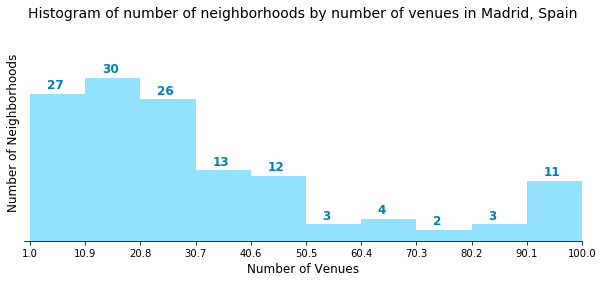

In [16]:
# np.histogram returns 2 values
count, bin_edges = np.histogram(neighborhoods['Number Venues'])

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

font_color = (0, 130, 179) # blue
font_color = webcolors.rgb_to_hex(font_color)
bar_color = (145, 225, 255) # light blue
bar_color = webcolors.rgb_to_hex(bar_color)

neighborhoods['Number Venues'].plot(kind='hist', figsize=(10, 4), xticks=bin_edges, color=bar_color)

plt.title('Histogram of number of neighborhoods by number of venues in Madrid, Spain', fontsize=14) # add a title to the histogram
plt.ylabel('Number of Neighborhoods', fontsize=12) # add y-label
plt.xlabel('Number of Venues', fontsize=12) # add x-label

for index, value in enumerate(count): 
    label = format(int(value), ',') # format int with commas
    # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(bin_edges[index]+3, value + 1), color=font_color, size=12, fontweight='bold')

# Remove frame lines at top, right and left
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

# https://www.delftstack.com/howto/matplotlib/how-to-hide-axis-text-ticks-and-or-tick-labels-in-matplotlib/
plt.gca().axes.get_yaxis().set_ticks([])
#plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().axes.get_xaxis().set_visible(True)

plt.ylim(ymax = 40) #, ymin = 25)     # Y Axis range
plt.xlim(xmax = 100, xmin = 0)        # X axis range

plt.show()

**Insights:**
* **82% neighborhoods** have below 50 venues each (62% neighborhoods have less than 30 venues): **more residential than urban neighborhoods**
* **18% neighborhoods** have more than 50 venues each, in 500 meters round: **more urban/centric places**
* **11 neighbourhoods (8%) have above 90 venues each**

Neighbourhoods with more than 90 venues are mainly located in the Center or Madrid: districts of Center, Salamanca, Chamberí and Carabanchel; well inside the city.

In [17]:
neighborhoods.loc[neighborhoods.loc[:, 'Number Venues']>=90, ['District', 'Neighborhood Code', 'Neighborhood', 'Number Venues']]

District  Neighborhood Code Neighborhood  Number Venues
1        Centro                 12  Embajadores          100.0
2        Centro                 13       Cortes          100.0
3        Centro                 14     Justicia          100.0
4        Centro                 15  Universidad          100.0
5        Centro                 16          Sol          100.0
19    Salamanca                 41    Recoletos          100.0
20    Salamanca                 42         Goya          100.0
23    Salamanca                 45        Lista          100.0
24    Salamanca                 46   Castellana          100.0
39     Chamberí                 73    Trafalgar          100.0
65  Carabanchel                111     Comillas          100.0

Neighborhoods with few venues (<10) are well outside the city (El Pardo, Aravaca, Barajas) or in the external belt/residential areas (Latina, Usera, Hortaleza, Villaverde, Vicálvaro, Canillejas)

In [18]:
neighborhoods.loc[neighborhoods.loc[:, 'Number Venues']<=10, ['District', 'Neighborhood Code', 'Neighborhood', 'Number Venues']]

District  Neighborhood Code                 Neighborhood  \
29             Chamartín                 55                 Nueva España   
44   Fuencarral-El Pardo                 82               Fuentelarreina   
45   Fuencarral-El Pardo                 83                   Peñagrande   
50   Fuencarral-El Pardo                 88                    El Goloso   
51       Moncloa-Aravaca                 91                Casa de Campo   
56       Moncloa-Aravaca                 96                   El Plantío   
63                Latina                106               Cuatro Vientos   
72                 Usera                121                    Orcasitas   
77                 Usera                126                        Zofío   
78                 Usera                127                   Pradolongo   
82    Puente de Vallecas                134            Palomeras Sureste   
85             Moratalaz                141                      Pavones   
98         Ciudad Lineal                158                      Atalaya   
100            Hortaleza                161                      Palomas   
101            Hortaleza                162                      Piovera   
105            Hortaleza                166                 Valdefuentes   
107           Villaverde                172                San Cristóbal   
108           Villaverde                173                     Butarque   
110           Villaverde                175                  Los Ángeles   
111    Villa de Vallecas                181  Casco Histórico de Vallecas   
117            Vicálvaro                194                 El Cañaveral   
118  San Blas-Canillejas                201                     Simancas   
119  San Blas-Canillejas                202                       Hellín   
120  San Blas-Canillejas                203                      Amposta   
122  San Blas-Canillejas                205                        Rosas   
123  San Blas-Canillejas                206                        Rejas   
129              Barajas                214                        Timón   

     Number Venues  
29             6.0  
44             6.0  
45             4.0  
50             4.0  
51             2.0  
56             5.0  
63             6.0  
72             9.0  
77             7.0  
78             5.0  
82             8.0  
85             9.0  
98             9.0  
100            9.0  
101            2.0  
105            2.0  
107            6.0  
108            5.0  
110            5.0  
111            8.0  
117            1.0  
118            8.0  
119            9.0  
120           10.0  
122            2.0  
123            4.0  
129            3.0

#### 4.2 Histogram of neighborhoods by surface

[126   3   1   0   0   0   0   0   0   1]
[  0.248   18.9874  37.7268  56.4662  75.2056  93.945  112.6844 131.4238
 150.1632 168.9026 187.642 ]


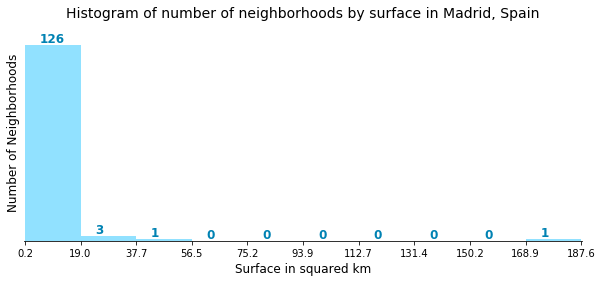

In [44]:
# np.histogram returns 2 values
data = neighborhoods['Neighborhood Surface']

count, bin_edges = np.histogram(data)

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

font_color = (0, 130, 179) # blue
font_color = webcolors.rgb_to_hex(font_color)
bar_color = (145, 225, 255) # light blue
bar_color = webcolors.rgb_to_hex(bar_color)

data.plot(kind='hist', figsize=(10, 4), xticks=bin_edges, color=bar_color)

plt.title('Histogram of number of neighborhoods by surface in Madrid, Spain', fontsize=14) # add a title to the histogram
plt.ylabel('Number of Neighborhoods', fontsize=12) # add y-label
plt.xlabel('Surface in squared km', fontsize=12) # add x-label

for index, value in enumerate(count): 
    label = format(int(value), ',') # format int with commas
    # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(bin_edges[index]+5, value +2), color=font_color, size=12, fontweight='bold')

# Remove frame lines at top, right and left
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

# https://www.delftstack.com/howto/matplotlib/how-to-hide-axis-text-ticks-and-or-tick-labels-in-matplotlib/
plt.gca().axes.get_yaxis().set_ticks([])
#plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().axes.get_xaxis().set_visible(True)

plt.ylim(ymax = 140) #, ymin = 25)     # Y Axis range
plt.xlim(xmax = 188, xmin = 0)        # X axis range

plt.show()

**Insights:**
* There are two clear outliers: 'El Pardo' and 'Casco Histórico de Vicálvaro'
* I will exclude them from the analysis and will repeat the chart

In [47]:
large_neighborhoods = neighborhoods.loc[neighborhoods.loc[:, 'Neighborhood Surface'] > 19]
number_large_neighborhoods = large_neighborhoods.shape[0]
print('{} large neighborhoods:'.format(number_large_neighborhoods))
large_neighborhoods

5 large neighborhoods:


District Code             District  District Surface  \
43               8  Fuencarral-El Pardo          23783.84   
50               8  Fuencarral-El Pardo          23783.84   
111             18    Villa de Vallecas           5146.72   
114             19            Vicálvaro           3526.67   
127             21              Barajas           4192.28   

     District Population  District density                  Neighborhood  \
43              238756.0             10.04                      El Pardo   
50              238756.0             10.04                     El Goloso   
111             104421.0             19.86   Casco Histórico de Vallecas   
114              70051.0             19.86  Casco Histórico de Vicálvaro   
127              46876.0             11.18                    Aeropuerto   

     Neighborhood Code  Neighborhood Surface   Latitude  Longitude  \
43                  81               187.642  40.520554  -3.778074   
50                  88                26.509  40.557883  -3.714013   
111                181                49.359  40.382999  -3.617000   
114                191                32.924  40.404202  -3.608060   
127                212                25.132  40.451820  -3.583740   

     Number Venues  Percentage Venues  ATM  Accessories Store  Adult Boutique  \
43            16.0           0.003792  0.0                0.0             0.0   
50             4.0           0.000948  0.0                0.0             0.0   
111            8.0           0.001896  0.0                0.0             0.0   
114           26.0           0.006163  0.0                0.0             0.0   
127           23.0           0.005452  0.0                0.0             0.0   

     Advertising Agency  Airport  American Restaurant  Arepa Restaurant  \
43                  0.0      0.0                  0.0               0.0   
50                  0.0      0.0                  0.0               0.0   
111                 0.0      0.0                  0.0               0.0   
114                 0.0      0.0                  0.0               0.0   
127                 0.0      0.0                  0.0               0.0   

     Argentinian Restaurant  Art Gallery  Art Museum  Art Studio  \
43                      0.0          0.0         0.0         0.0   
50                      0.0          0.0         0.0         0.0   
111                     0.0          0.0         0.0         0.0   
114                     0.0          0.0         0.0         0.0   
127                     0.0          0.0         0.0         0.0   

     Arts & Crafts Store  Asian Restaurant  Astrologer  Athletics & Sports  \
43                   0.0          0.000000         0.0                 0.0   
50                   0.0          0.000000         0.0                 0.0   
111                  0.0          0.000000         0.0                 0.0   
114                  0.0          0.038462         0.0                 0.0   
127                  0.0          0.000000         0.0                 0.0   

     Auto Dealership  Auto Garage  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
43               0.0          0.0        0.0         0.0         0.0  0.0625   
50               0.0          0.0        0.0         0.0         0.0  0.0000   
111              0.0          0.0        0.0         0.0         0.0  0.0000   
114              0.0          0.0        0.0         0.0         0.0  0.0000   
127              0.0          0.0        0.0         0.0         0.0  0.0000   

     Bank    Bar  Basketball Court  Basketball Stadium  Bed & Breakfast  \
43    0.0  0.000               0.0                 0.0              0.0   
50    0.0  0.000               0.0                 0.0              0.0   
111   0.0  0.125               0.0                 0.0              0.0   
114   0.0  0.000               0.0                 0.0              0.0   
127   0.0  0.000               0.0                 0.0              0.0   

     Beer Ba

El Pardo is the largest neighborhood of the city, but it is also a protected, natural and touristic area, so it has low population density but relatively a large number of venues compared with other large neighborhoods. This is clearly an outlier: this neighborhood has its own characteristics.

[107   9   7   0   1   2   0   1   1   1]
[ 0.248   3.5156  6.7832 10.0508 13.3184 16.586  19.8536 23.1212 26.3888
 29.6564 32.924 ]


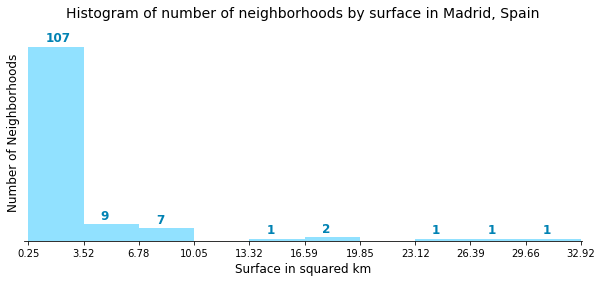

In [48]:
# np.histogram returns 2 values
data = neighborhoods['Neighborhood Surface']
data = data.drop([43])   # I remove line 43: 'El Pardo'
#data = data.drop([50])  
data = data.drop([111])  # Casco Histórico de Vallecas
#data = data.drop([114])   
#data = data.drop([127])   

count, bin_edges = np.histogram(data)

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

font_color = (0, 130, 179) # blue
font_color = webcolors.rgb_to_hex(font_color)
bar_color = (145, 225, 255) # light blue
bar_color = webcolors.rgb_to_hex(bar_color)

data.plot(kind='hist', figsize=(10, 4), xticks=bin_edges, color=bar_color)

plt.title('Histogram of number of neighborhoods by surface in Madrid, Spain', fontsize=14) # add a title to the histogram
plt.ylabel('Number of Neighborhoods', fontsize=12) # add y-label
plt.xlabel('Surface in squared km', fontsize=12) # add x-label

for index, value in enumerate(count): 
    label = format(int(value), ',') # format int with commas
    # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    if int(value) > 0:
        plt.annotate(label, xy=(bin_edges[index]+1, value+3), color=font_color, size=12, fontweight='bold')

# Remove frame lines at top, right and left
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

# https://www.delftstack.com/howto/matplotlib/how-to-hide-axis-text-ticks-and-or-tick-labels-in-matplotlib/
plt.gca().axes.get_yaxis().set_ticks([])
#plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().axes.get_xaxis().set_visible(True)

plt.ylim(ymax = 120) #, ymin = 25)     # Y Axis range
plt.xlim(xmax = 33, xmin = 0)        # X axis range

plt.show()

**Insights:**
* **82% neighborhoods are small** in surface (below 3,5 square km)
* only 8 neighborhoods above 10 square km surface

#### 4.3 Histogram of neighborhoods by density of population

[27  6 20  0  0 32  9 13  6 18]
[ 10.04  38.4   66.76  95.12 123.48 151.84 180.2  208.56 236.92 265.28
 293.64]


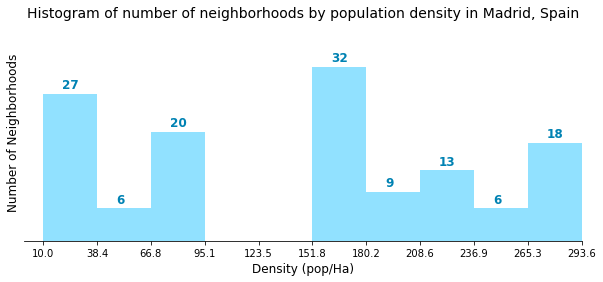

In [49]:
# np.histogram returns 2 values
data = neighborhoods['District density']

count, bin_edges = np.histogram(data)

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

font_color = (0, 130, 179) # blue
font_color = webcolors.rgb_to_hex(font_color)
bar_color = (145, 225, 255) # light blue
bar_color = webcolors.rgb_to_hex(bar_color)

data.plot(kind='hist', figsize=(10, 4), xticks=bin_edges, color=bar_color)

plt.title('Histogram of number of neighborhoods by population density in Madrid, Spain', fontsize=14) # add a title to the histogram
plt.ylabel('Number of Neighborhoods', fontsize=12) # add y-label
plt.xlabel('Density (pop/Ha)', fontsize=12) # add x-label

for index, value in enumerate(count): 
    label = format(int(value), ',') # format int with commas
    # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    if int(value) > 0:
        plt.annotate(label, xy=(bin_edges[index]+10, value+1), color=font_color, size=12, fontweight='bold')

# Remove frame lines at top, right and left
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

# https://www.delftstack.com/howto/matplotlib/how-to-hide-axis-text-ticks-and-or-tick-labels-in-matplotlib/
plt.gca().axes.get_yaxis().set_ticks([])
#plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().axes.get_xaxis().set_visible(True)

plt.ylim(ymax = 40) #, ymin = 25)     # Y Axis range
plt.xlim(xmax = 294, xmin = 0)        # X axis range

plt.show()

**Insights:**
* **There are two clear groups of districts by density of population**:
    * Below 95 inhabitants per squared Ha: 40% neighborhoods
    * Above 151 inhabitants per squared Ha: 60% neighborhoods

More populated districts are: Chamberí, Tetuán and Salamanca, in the core of the municipality:

In [50]:
neighborhoods.loc[neighborhoods.loc[:, 'District density']>=265, ['District', 'Neighborhood Code', 'Neighborhood', 'District density', 'Number Venues']]

District  Neighborhood Code      Neighborhood  District density  \
19  Salamanca                 41         Recoletos            266.67   
20  Salamanca                 42              Goya            266.67   
21  Salamanca                 43  Fuente del Berro            266.67   
22  Salamanca                 44     La Guindalera            266.67   
23  Salamanca                 45             Lista            266.67   
24  Salamanca                 46        Castellana            266.67   
31     Tetuán                 61     Bellas Vistas            286.13   
32     Tetuán                 62    Cuatro Caminos            286.13   
33     Tetuán                 63       Castillejos            286.13   
34     Tetuán                 64          Almenara            286.13   
35     Tetuán                 65     Valdeacederas            286.13   
36     Tetuán                 66        Berruguete            286.13   
37   Chamberí                 71        Gaztambide            293.64   
38   Chamberí                 72          Arapiles            293.64   
39   Chamberí                 73         Trafalgar            293.64   
40   Chamberí                 74           Almagro            293.64   
41   Chamberí                 75        Ríos Rosas            293.64   
42   Chamberí                 76      Vallehermoso            293.64   

    Number Venues  
19          100.0  
20          100.0  
21           18.0  
22           28.0  
23          100.0  
24          100.0  
31           14.0  
32           42.0  
33           56.0  
34           15.0  
35           24.0  
36           43.0  
37           85.0  
38           79.0  
39          100.0  
40           88.0  
41           64.0  
42           25.0

Less populated neighborhoods are the ones that are further from the center: El Pardo, Barajas, Vicálvaro, Villa de Vallecas and Aravaca:

In [51]:
neighborhoods.loc[neighborhoods.loc[:, 'District density']<=30, ['District', 'Neighborhood Code', 'Neighborhood', 'District density', 'Number Venues']]

District  Neighborhood Code                  Neighborhood  \
43   Fuencarral-El Pardo                 81                      El Pardo   
44   Fuencarral-El Pardo                 82                Fuentelarreina   
45   Fuencarral-El Pardo                 83                    Peñagrande   
46   Fuencarral-El Pardo                 84                      El Pilar   
47   Fuencarral-El Pardo                 85                        La Paz   
48   Fuencarral-El Pardo                 86                      Valverde   
49   Fuencarral-El Pardo                 87                    Mirasierra   
50   Fuencarral-El Pardo                 88                     El Goloso   
51       Moncloa-Aravaca                 91                 Casa de Campo   
52       Moncloa-Aravaca                 92                     Argüelles   
53       Moncloa-Aravaca                 93          Ciudad Universitaria   
54       Moncloa-Aravaca                 94                    Valdezarza   
55       Moncloa-Aravaca                 95                    Valdemarín   
56       Moncloa-Aravaca                 96                    El Plantío   
57       Moncloa-Aravaca                 97                       Aravaca   
111    Villa de Vallecas                181   Casco Histórico de Vallecas   
112    Villa de Vallecas                182                 Santa Eugenia   
113    Villa de Vallecas                183          Ensanche de Vallecas   
114            Vicálvaro                191  Casco Histórico de Vicálvaro   
115            Vicálvaro                192                 Valdebernardo   
116            Vicálvaro                193                   Valderrivas   
117            Vicálvaro                194                  El Cañaveral   
126              Barajas                211              Alameda de Osuna   
127              Barajas                212                    Aeropuerto   
128              Barajas                213    Casco Histórico de Barajas   
129              Barajas                214                         Timón   
130              Barajas                215                    Corralejos   

     District density  Number Venues  
43              10.04           16.0  
44              10.04            6.0  
45              10.04            4.0  
46              10.04           74.0  
47              10.04           14.0  
48              10.04           16.0  
49              10.04           16.0  
50              10.04            4.0  
51              25.12            2.0  
52              25.12           65.0  
53              25.12           13.0  
54              25.12           14.0  
55              25.12           25.0  
56              25.12            5.0  
57              25.12           25.0  
111             19.86            8.0  
112             19.86           17.0  
113             19.86           82.0  
114             19.86           26.0  
115             19.86           24.0  
116             19.86           16.0  
117             19.86            1.0  
126             11.18           31.0  
127             11.18           23.0  
128             11.18           44.0  
129             11.18            3.0  
130             11.18           19.0

#### 4.4 Is there a relation between number of venues, surface and density of population by neighborhood? 
Lets check it with scatter-plots and linear regressions

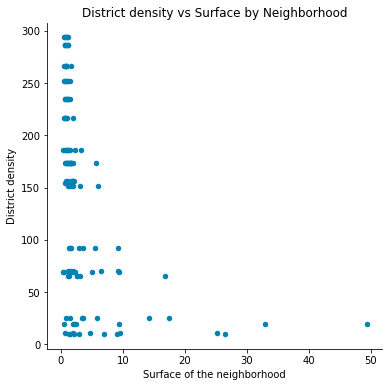

In [52]:
# Scatterplot between Surface and density
data = neighborhoods[['Neighborhood Surface', 'District density']]
data = data.drop([43])   # I remove line 43: 'El Pardo'

font_color = (0, 130, 179) # blue
font_color = webcolors.rgb_to_hex(font_color)
bar_color = (145, 225, 255) # light blue
bar_color = webcolors.rgb_to_hex(bar_color)

data.plot(kind='scatter', x='Neighborhood Surface', y='District density', figsize=(6, 6), color=font_color)

plt.title('District density vs Surface by Neighborhood')
plt.xlabel('Surface of the neighborhood')
plt.ylabel('District density')

# Remove frame lines at top, right and left
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

plt.show()

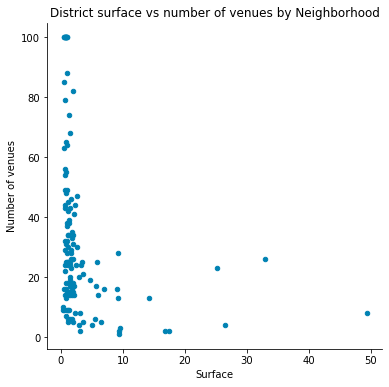

In [53]:
# Scatterplot between Surface and number of venues
data = neighborhoods[['Number Venues', 'Neighborhood Surface']]
data = data.drop([43])   # I remove line 43: 'El Pardo'

font_color = (0, 130, 179) # blue
font_color = webcolors.rgb_to_hex(font_color)
bar_color = (145, 225, 255) # light blue
bar_color = webcolors.rgb_to_hex(bar_color)

data.plot(kind='scatter', x='Neighborhood Surface', y='Number Venues', figsize=(6, 6), color=font_color)

plt.title('District surface vs number of venues by Neighborhood')
plt.xlabel('Surface')
plt.ylabel('Number of venues')

# Remove frame lines at top, right and left
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

plt.show()

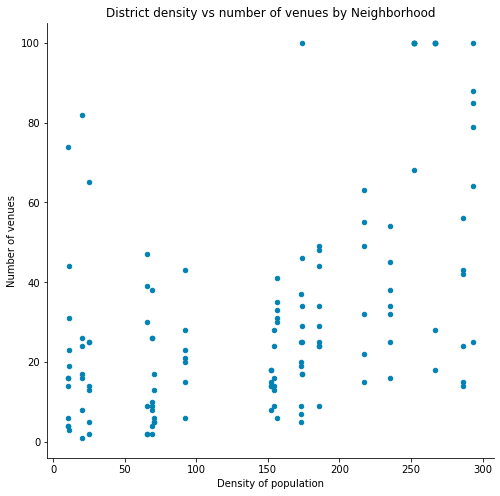

In [54]:
# Scatterplot between Number of venues and density
data = neighborhoods[['Number Venues', 'District density']]
data = data.drop([43])   # I remove line 43: 'El Pardo'

font_color = (0, 130, 179) # blue
font_color = webcolors.rgb_to_hex(font_color)
bar_color = (145, 225, 255) # light blue
bar_color = webcolors.rgb_to_hex(bar_color)

data.plot(kind='scatter', x='District density', y='Number Venues', figsize=(8, 8), color=font_color)

plt.title('District density vs number of venues by Neighborhood')
plt.xlabel('Density of population')
plt.ylabel('Number of venues')

# Remove frame lines at top, right and left
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

plt.show()

So let's try to plot a linear line of best fit, and use it to  predict the number of venues depending on density of population.

Step 1: Get the equation of line of best fit. We will use **Numpy**'s `polyfit()` method by passing in the following:
- `x`: x-coordinates of the data. 
- `y`: y-coordinates of the data. 
- `deg`: Degree of fitting polynomial. 1 = linear, 2 = quadratic, and so on.

In [55]:
x = neighborhoods['District density']     
y = neighborhoods['Number Venues']     

fit = np.polyfit(x, y, deg=1)

fit

array([0.15621779, 9.76848563])

The output is an array with the polynomial coefficients, highest powers first. Since we are plotting a linear regression `y= a*x + b`, our output has 2 elements with the the slope in position 0 and intercept in position 1. 

Step 2: Plot the regression line on the `scatter plot`.

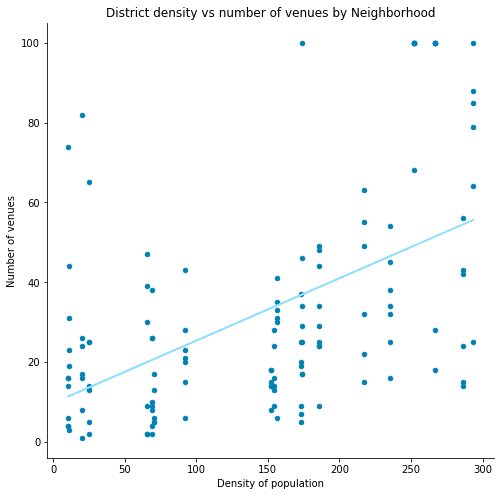

In [56]:
# Scatterplot between Number of venues and density
data = neighborhoods[['Number Venues', 'District density']]
data = data.drop([43])   # I remove line 43: 'El Pardo'

font_color = (0, 130, 179) # blue
font_color = webcolors.rgb_to_hex(font_color)
bar_color = (145, 225, 255) # light blue
bar_color = webcolors.rgb_to_hex(bar_color)

data.plot(kind='scatter', x='District density', y='Number Venues', figsize=(8, 8), color=font_color)

plt.title('District density vs number of venues by Neighborhood')
plt.xlabel('Density of population')
plt.ylabel('Number of venues')

# Remove frame lines at top, right and left
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

# plot line of best fit
plt.plot(x, fit[0] * x + fit[1], color=bar_color)

plt.show()

# print out the line of best fit
#'No. Venues = {0:.0f} * Pop.Density + {1:.0f}'.format(fit[0], fit[1]) 

Text(0.5, 1.0, 'District density vs number of venues by Neighborhood')

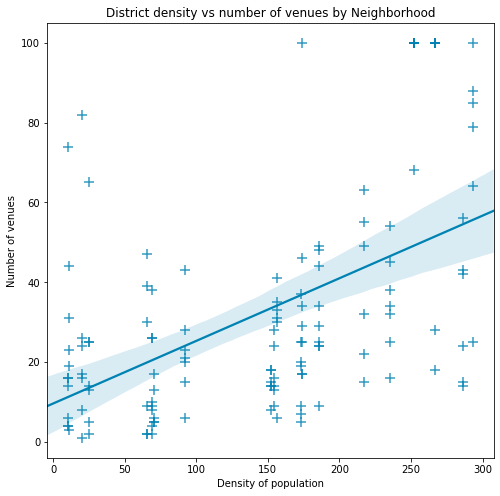

In [57]:
# Scatterplot between Number of venues and density
data = neighborhoods[['Number Venues', 'District density']]
data = data.drop([43])   # I remove line 43: 'El Pardo'

font_color = (0, 130, 179) # blue
font_color = webcolors.rgb_to_hex(font_color)
bar_color = (145, 225, 255) # light blue
bar_color = webcolors.rgb_to_hex(bar_color)

plt.figure(figsize=(8, 8))
#sns.set(font_scale=1.5)
#sns.set_style('whitegrid')

ax = sns.regplot(x='District density', y='Number Venues', data=data, color=font_color, marker='+', scatter_kws={'s': 100})  # , marker='+'
ax.set(xlabel='Density of population', ylabel='Number of venues')
ax.set_title('District density vs number of venues by Neighborhood')


**Insights:**
* Most neighborhoods are small in surface, but it doesn't mean that they have high density population or high number of venues
* Larger neighborhoods tend to be less densely populated and with less venues
* There is no clear correlation between density of population and number of venues, though sometimes there can be some relation
* There could be a non-linear relation between surface and density/number of venues, though it is of no real interest for us trying to predict that variables: we already have a measure...

#### 4.5 Let's try a bubble chart with these three variables

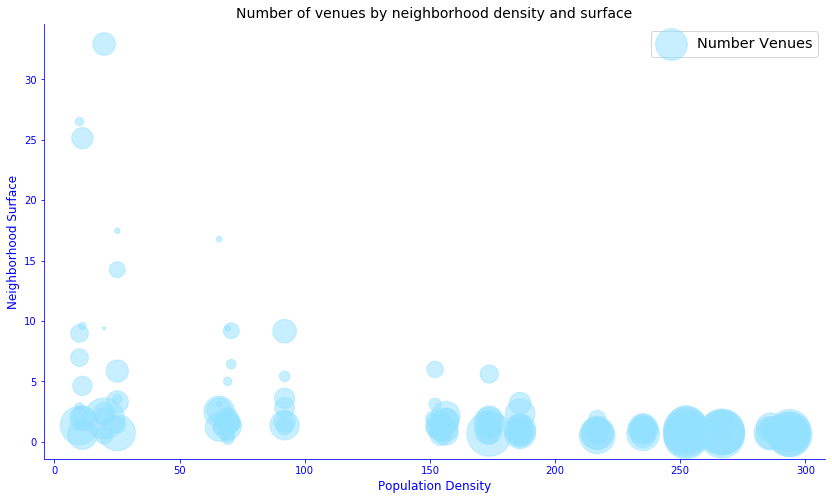

In [58]:
# Bubble chart
data = neighborhoods[['Neighborhood','Number Venues', 'District density', 'Neighborhood Surface']]
data = data.drop([43])   # I remove line 43: 'El Pardo'
data = data.drop([111])   # I remove line 111: 'Casco Histórico de Vallecas'
#data.set_index('District density', inplace = True)  # set category as index

#font_color = (0, 130, 179) # blue
#bar_color = (145, 225, 255) # light blue

norm_madrid = (data['Number Venues'] - data['Number Venues'].min()) / (data['Number Venues'].max() - data['Number Venues'].min())

ax0 = data.plot(kind='scatter',
                x='District density',
                y='Neighborhood Surface',
                figsize=(14, 8),
                alpha=0.5,                  # transparency
                color=bar_color,
                s=norm_madrid * 2000 + 10  # pass in weights
                #xlim=(1975, 2015)
               )

ax0.set_ylabel('Neighborhood Surface', fontsize=12)
ax0.set_xlabel('Population Density', fontsize=12)
ax0.set_title('Number of venues by neighborhood density and surface', fontsize=14)
ax0.legend(['Number Venues'], loc='upper right', fontsize='x-large')

# Remove frame lines at top, right and left
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

ax0.spines['bottom'].set_color('blue')
#ax0.spines['top'].set_color('blue') 
#ax0.spines['right'].set_color('blue')
ax0.spines['left'].set_color('blue')
ax0.tick_params(axis='x', colors='blue')
ax0.tick_params(axis='y', colors='blue')
ax0.yaxis.label.set_color('blue')
ax0.xaxis.label.set_color('blue')

**Insights:**
* It is more frequent to have high number of venues in high population neighborhoods. Lower number of venues only appear at low density neighborhoods (below 200 pop/Ha), but it is not a linear relation
* Larger neighborhoods could be bad dimensioned at taking only 500 meters around venues doesn't cover the whole neighborhood surface
* It seems that the **number of venues is usually high**, no matter the population density
* Higher number of venues are in smaller neighborhoods

#### 4.6 Let's see the most frequent venues categories in Madrid

In [59]:
# We group the venues by venue category
madrid_venues_grouped = madrid_venues.groupby('Venue Category').count().reset_index()
# Clean the dataframe
madrid_venues_grouped.rename(columns={'Neighborhood': 'Count'}, inplace=True)
madrid_venues_grouped.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude'], axis = 1, inplace=True)
# Order by number of venues
madrid_venues_grouped = madrid_venues_grouped.sort_values(['Count'], ascending = False)

print(madrid_venues_grouped.shape)
madrid_venues_grouped.head()

(304, 2)


Venue Category  Count
264  Spanish Restaurant    374
236          Restaurant    245
275    Tapas Restaurant    163
22                  Bar    157
142               Hotel    117

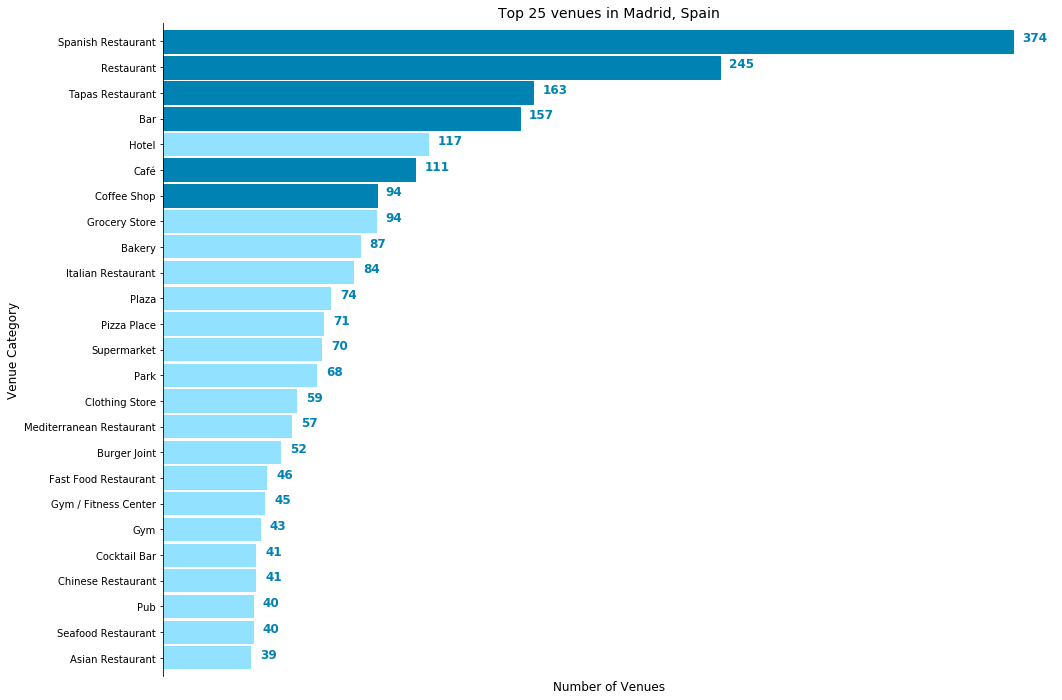

In [61]:
kVenues = 25
data = madrid_venues_grouped.head(kVenues)   # top venues in Madrid
data.set_index('Venue Category', inplace = True)  # set category as index
data = data.sort_values(['Count'], ascending = True)

# font_color = (0, 130, 179) # blue
# bar_color = (145, 225, 255) # light blue

data.plot(kind='barh', figsize=(16,12), color=bar_color, width=0.9)
plt.xlabel('Number of Venues', fontsize=12)
plt.ylabel('Venue Category', fontsize=12)
plt.title('Top {} venues in Madrid, Spain'.format(kVenues), fontsize=14)

for index, value in enumerate(data['Count']): 
    label = '{:d}'.format(value) # format int with commas
    plt.annotate(label, xy=(value+4, index), color=font_color, size=12, fontweight='bold')

# Remove frame lines at top, right and left
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().axes.get_xaxis().set_ticks([])

# Bar Colors
plt.gca().get_children()[24].set_color(font_color)
plt.gca().get_children()[23].set_color(font_color)
plt.gca().get_children()[22].set_color(font_color)
plt.gca().get_children()[21].set_color(font_color)
plt.gca().get_children()[19].set_color(font_color)
plt.gca().get_children()[18].set_color(font_color)

plt.gca().get_legend().remove()

#plt.ylim(ymax = 40) #, ymin = 25)     # Y Axis range
#plt.xlim(xmax = 294, xmin = 0)        # X axis range
    
plt.show()

**Insights:**
* **First 6 out of 7 categories are gastronomic and social places**: 'Tapas' and Spaniard restaurants, pubs ('bar'), and coffee shops
* **Other top categories** are: (#6) **Hotels**, (#8) **Bakery**, (#9) **Grocery stores**, (#10) **Italian restaurants**
* **29% venues in Madrid** (according to the sample), **14 out of 25 top venues are gastronomic and social places**
* **Tourism is important for Madrid**: this is why Hotels come after restaurants
* It is not all restaurants and hotels: **Madrid also has Parks, places to have a walk, Bookstores, Gyms**... and lots of museums, though they are not at the top 25 venues

### 4.7 Let's cluster the neighborhoods by kind of venues, and see what results...

#### 4.7.1 K-Mean algorithm: clustering by number of venues and short of venues

In [19]:
# set number of clusters
kclusters = 5

# Data
#columns = {'District Code', 'District', 'District Surface', 'District Population', 'District density', 'Neighborhood', 'Neighborhood Code', 'Neighborhood Surface', 'Latitude', 'Longitude', 'Number Venues'}
madrid_clustering = neighborhoods.drop(['District Code', 'District', 'District Surface', 
                                       'District Population', 'District density', 'Neighborhood', 
                                       'Neighborhood Code', 'Neighborhood Surface', 'Latitude', 
                                       'Longitude', 'Number Venues'], axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_clustering)

# add clustering labels
neighborhoods_clustered1 = neighborhoods.copy()
neighborhoods_clustered1.insert(0, 'Cluster Labels', kmeans.labels_)

top_venues1 = neighborhoods_venues_sorted.copy()
top_venues1.insert(0, 'Cluster Labels', kmeans.labels_)

print(top_venues1.shape, neighborhoods_clustered1.shape)

(131, 13) (131, 316)


In [27]:
# create map of clusters:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set personalized color scheme for the clusters
color_names = ('blue', 'green', 'orange', 'red', 'white') #, 'black', 'cyan', 'gold') #, 'gray', 'pink', 'magenta', 'brown')
rainbow = [webcolors.name_to_hex(name) for name in color_names]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_clustered1['Latitude'], neighborhoods_clustered1['Longitude'], neighborhoods_clustered1['Neighborhood'], neighborhoods_clustered1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

**Cluster 1 (White): Not too crowded, not to residential, not so much for gourmets... That neighborhoods have just around 30 venues average, mainly Italian and fast food restaurants, pubs, and also supermarkets, bakeries, groceries and convenient stores (technology, mobile phones). Outside the touristic area.**

In [21]:
cluster_number = 0
cluster = top_venues1.loc[top_venues1['Cluster Labels'] == cluster_number, top_venues1.columns[[1, 2] + list(range(3, top_venues1.shape[1]))]]
cluster2 = neighborhoods_clustered1.loc[neighborhoods_clustered1['Cluster Labels'] == cluster_number, neighborhoods_clustered1.columns[[1, 2] + list(range(3, neighborhoods_clustered1.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 59 neighborhoods included with color white
Mean number of venues: 30.2. Minimum: 2.0, Maximum: 100.0


Neighborhood  Percentage Venues    1st Most Common Venue  \
1                     Embajadores           0.023702                      Bar   
4                     Universidad           0.023702                      Bar   
5                             Sol           0.023702                    Hotel   
7                         Acacias           0.010666                      Bar   
8                         Chopera           0.007585                     Park   
10                       Delicias           0.008059               Restaurant   
11                Palos de Moguer           0.012799               Restaurant   
13                       Pacífico           0.013036            Grocery Store   
14                        Adelfas           0.011614            Grocery Store   
15                       Estrella           0.007585             Cocktail Bar   
30                       Castilla           0.009718                 Platform   
34                       Almenara           0.003555       Seafood Restaurant   
36                     Berruguete           0.010192         Tapas Restaurant   
45                     Peñagrande           0.000948           Breakfast Spot   
46                       El Pilar           0.017540         Tapas Restaurant   
48                       Valverde           0.003792            Train Station   
49                     Mirasierra           0.003792                  Brewery   
51                  Casa de Campo           0.000474                BBQ Joint   
53           Ciudad Universitaria           0.003081               Restaurant   
57                        Aravaca           0.005926             Soccer Field   
60                         Lucero           0.005452     Fast Food Restaurant   
61                         Aluche           0.004740               Restaurant   
62                     Campamento           0.006637            Grocery Store   
66                         Opañel           0.005926                      Bar   
68                   Vista Alegre           0.010903            Grocery Store   
69                  Puerta Bonita           0.006874                      Bar   
70                     Buenavista           0.004029                      Gym   
71                       Abrantes           0.004029            Grocery Store   
72                      Orcasitas           0.002133       Spanish Restaurant   
73                        Orcasur           0.004740              Coffee Shop   
74                     San Fermín           0.004503   Furniture / Home Store   
76                       Moscardó           0.008770               Restaurant   
79                      Entrevías           0.003318                   Bakery   
81                Palomeras Bajas           0.003318  Health & Beauty Service   
82              Palomeras Sureste           0.001896              Pizza Place   
83                       Portazgo           0.004266                      Bar   
84                       Numancia           0.004266        Food & Drink Shop   
85                        Pavones           0.002133            Grocery Store   
86                        Horcajo           0.003081     Fast Food Restaurant   
88                    Media Legua           0.006637              Coffee Shop   
89                      Fontarrón           0.003318               Playground   
90                      Vinateros           0.005689                      Bar   
92                   Pueblo Nuevo           0.010429     Fast Food Restaurant   
93                       Quintana           0.011377           Clothing Store   
94                     Concepción           0.005926                      Bar   
99                    Costillares           0.005689     Gym / Fitness Center   
100                       Palomas           0.002133       Spanish Restaurant   
103                 Pinar del Rey           0.007111                      Gym   
104              Apóstol Santiago           0.009244

**Cluster 2 (Blue): quiet residential zones with just a few venues around (mean = 10), mainly 'Spaniard restaurants and parks'**

In [22]:
cluster_number = 1
cluster = top_venues1.loc[top_venues1['Cluster Labels'] == cluster_number, top_venues1.columns[[1, 2] + list(range(3, top_venues1.shape[1]))]]
cluster2 = neighborhoods_clustered1.loc[neighborhoods_clustered1['Cluster Labels'] == cluster_number, neighborhoods_clustered1.columns[[1, 2] + list(range(3, neighborhoods_clustered1.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 10 neighborhoods included with color blue
Mean number of venues: 7.9. Minimum: 2.0, Maximum: 16.0


Neighborhood  Percentage Venues   1st Most Common Venue  \
17        Jerónimos           0.003555                    Park   
44   Fuentelarreina           0.001422                    Park   
63   Cuatro Vientos           0.001422                    Park   
78       Pradolongo           0.001185                    Park   
87       Marroquina           0.003792                    Park   
105    Valdefuentes           0.000474                    Park   
107   San Cristóbal           0.001422  Furniture / Home Store   
108        Butarque           0.001185                   Plaza   
118        Simancas           0.001896                    Park   
120         Amposta           0.002370             Supermarket   

          2nd Most Common Venue 3rd Most Common Venue  \
17          Monument / Landmark            Art Museum   
44                 Soccer Field                Bakery   
63                          Bar    Athletics & Sports   
78                        Plaza               Theater   
87   Construction & Landscaping                 Plaza   
105                  Skate Park           Flea Market   
107               Train Station                  Park   
108                        Park            Sports Bar   
118                 Supermarket           Music Venue   
120          Spanish Restaurant         Jewelry Store   

          4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
17                      Exhibit                Church              Fountain   
44           Miscellaneous Shop                   Gym      Football Stadium   
63                  Bus Station         Train Station         Metro Station   
78   Construction & Landscaping           Beer Garden           Flea Market   
87                 Soccer Field           Supermarket                Lawyer   
105                        Farm        Farmers Market  Fast Food Restaurant   
107          Athletics & Sports             Locksmith        Breakfast Spot   
108                   Bookstore         Grocery Store           Yoga Studio   
118               Jewelry Store    Recycling Facility                  Food   
120          Recycling Facility                  Park                  Food   

          7th Most Common Venue       8th Most Common Venue  \
17                       Garden                    Tea Room   
44                   Food Truck                    Fountain   
63                  Flower Shop  Financial or Legal Service   
78               Farmers Market        Fast Food Restaurant   
87                   Restaurant         Rental Car Location   
105  Financial or Legal Service           Fish & Chips Shop   
107                    Dive Bar        Fast Food Restaurant   
108                 Flea Market              Farmers Market   
118               Metro Station                 Fish Market   
120                 Music Venue               Metro Station   

          9th Most Common Venue      10th Most Common Venue  
17                        Plaza                       Hotel  
44                   Food Stand           Food & Drink Shop  
63            Fish & Chips Shop                 Fish Market  
78   Financial or Legal Service           Fish & Chips Shop  
87                   Food Truck                Dessert Shop  
105                 Fish Market                 Yoga Studio  
107  Financial or Legal Service           Fish & Chips Shop  
108        Fast Food Restaurant  Financial or Legal Service  
118                        Farm              Farmers Market  
120            Dentist's Office                  Hobby Shop

**Cluster 3 (green): central neighborhoods of Madrid, with lots of possibilities around (mean: 40 venues), mainly restaurants of every kind, pubs and coffee shops, but also with lots of supermarkets, bakeries, gyms, hotels, parks, underground (half of them)**

In [23]:
cluster_number = 2
cluster = top_venues1.loc[top_venues1['Cluster Labels'] == cluster_number, top_venues1.columns[[1, 2] + list(range(3, top_venues1.shape[1]))]]
cluster2 = neighborhoods_clustered1.loc[neighborhoods_clustered1['Cluster Labels'] == cluster_number, neighborhoods_clustered1.columns[[1, 2] + list(range(3, neighborhoods_clustered1.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 60 neighborhoods included with color green
Mean number of venues: 39.3. Minimum: 3.0, Maximum: 100.0


Neighborhood  Percentage Venues 1st Most Common Venue  \
0                        Palacio           0.016118      Tapas Restaurant   
2                         Cortes           0.023702    Spanish Restaurant   
3                       Justicia           0.023702    Spanish Restaurant   
6                       Imperial           0.009007    Spanish Restaurant   
9                        Legazpi           0.005926    Spanish Restaurant   
12                        Atocha           0.003792            Restaurant   
16                         Ibiza           0.014932    Spanish Restaurant   
18                    Niño Jesús           0.005215    Spanish Restaurant   
19                     Recoletos           0.023702            Restaurant   
20                          Goya           0.023702    Spanish Restaurant   
21              Fuente del Berro           0.004266    Spanish Restaurant   
22                 La Guindalera           0.006637    Spanish Restaurant   
23                         Lista           0.023702    Spanish Restaurant   
24                    Castellana           0.023702    Spanish Restaurant   
25                       El Viso           0.007822    Spanish Restaurant   
26                   Prosperidad           0.007111      Tapas Restaurant   
27                 Ciudad Jardín           0.007348    Spanish Restaurant   
28                Hispanoamérica           0.008296    Spanish Restaurant   
29                  Nueva España           0.001422            Restaurant   
31                 Bellas Vistas           0.003318    Spanish Restaurant   
32                Cuatro Caminos           0.009955    Spanish Restaurant   
33                   Castillejos           0.013273    Spanish Restaurant   
35                 Valdeacederas           0.005689    Spanish Restaurant   
37                    Gaztambide           0.020147    Spanish Restaurant   
38                      Arapiles           0.018725    Spanish Restaurant   
39                     Trafalgar           0.023702            Restaurant   
40                       Almagro           0.020858    Spanish Restaurant   
41                    Ríos Rosas           0.015169            Restaurant   
42                  Vallehermoso           0.005926            Restaurant   
43                      El Pardo           0.003792    Spanish Restaurant   
47                        La Paz           0.003318    Spanish Restaurant   
50                     El Goloso           0.000948    Spanish Restaurant   
52                     Argüelles           0.015406    Spanish Restaurant   
54                    Valdezarza           0.003318    Spanish Restaurant   
55                    Valdemarín           0.005926            Restaurant   
56                    El Plantío           0.001185    Spanish Restaurant   
58                  Los Cármenes           0.003555            Restaurant   
59              Puerta del Ángel           0.010192    Spanish Restaurant   
64                   Las Águilas           0.004977                   Bar   
65                      Comillas           0.023702    Spanish Restaurant   
67                    San Isidro           0.008059    Spanish Restaurant   
75                   Almendrales           0.005926    Spanish Restaurant   
77                         Zofío           0.001659    Spanish Restaurant   
80                     San Diego           0.003555    Spanish Restaurant   
91                        Ventas           0.005689    Spanish Restaurant   
95                   San Pascual           0.008059    Spanish Restaurant   
96             San Juan Bautista           0.011614    Spanish Restaurant   
97                        Colina           0.006874    Spanish Restaurant   
98                       Atalaya           0.002133    Spanish Restaurant   
102                     Canillas           0.011140    Spanish Restaurant   
110                  Los Ángeles           0.001185    Spanish Restaurant   
111  Casco Histó

**Cluster 4 (orange): Piovera neighborhood. A fully residential place with just a relevant sports stadium and a sporting goods shop around**

In [24]:
cluster_number = 3
cluster = top_venues1.loc[top_venues1['Cluster Labels'] == cluster_number, top_venues1.columns[[1, 2] + list(range(3, top_venues1.shape[1]))]]
cluster2 = neighborhoods_clustered1.loc[neighborhoods_clustered1['Cluster Labels'] == cluster_number, neighborhoods_clustered1.columns[[1, 2] + list(range(3, neighborhoods_clustered1.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 1 neighborhoods included with color orange
Mean number of venues: 2.0. Minimum: 2.0, Maximum: 2.0


Neighborhood  Percentage Venues 1st Most Common Venue  \
101      Piovera           0.000474   Sporting Goods Shop   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
101               Stadium                  Food        Farmers Market   

    5th Most Common Venue       6th Most Common Venue 7th Most Common Venue  \
101  Fast Food Restaurant  Financial or Legal Service     Fish & Chips Shop   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
101           Fish Market           Flea Market            Flower Shop

**Cluster 5 (red): El Cañaveral... a residential neighborhood far from the center of the city with only a Mediterranean restaurant to go to**

In [25]:
cluster_number = 4
cluster = top_venues1.loc[top_venues1['Cluster Labels'] == cluster_number, top_venues1.columns[[1, 2] + list(range(3, top_venues1.shape[1]))]]
cluster2 = neighborhoods_clustered1.loc[neighborhoods_clustered1['Cluster Labels'] == cluster_number, neighborhoods_clustered1.columns[[1, 2] + list(range(3, neighborhoods_clustered1.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 1 neighborhoods included with color red
Mean number of venues: 1.0. Minimum: 1.0, Maximum: 1.0


Neighborhood  Percentage Venues     1st Most Common Venue  \
117  El Cañaveral           0.000237  Mediterranean Restaurant   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
117           Yoga Studio           Flower Shop        Farmers Market   

    5th Most Common Venue       6th Most Common Venue 7th Most Common Venue  \
117  Fast Food Restaurant  Financial or Legal Service     Fish & Chips Shop   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
117           Fish Market           Flea Market                   Food

#### 4.7.2 K-Mean algorithm: clustering by short of venues (no impact of number of venues)
* The result was exactly the same of 4.7.1: same clusters...
* 'Percentage of venues' over total has no major impact on the clustering exercise

In [28]:
# set number of clusters
kclusters = 5

# Data
madrid_clustering = neighborhoods.drop(['District Code', 'District', 'District Surface', 
                                       'District Population', 'District density', 'Neighborhood', 
                                       'Neighborhood Code', 'Neighborhood Surface', 'Latitude', 
                                       'Longitude', 'Number Venues', 'Percentage Venues'], axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_clustering)

# add clustering labels
neighborhoods_clustered2 = neighborhoods.copy()
neighborhoods_clustered2.insert(0, 'Cluster Labels', kmeans.labels_)

top_venues2 = neighborhoods_venues_sorted.copy()
top_venues2.insert(0, 'Cluster Labels', kmeans.labels_)

print(top_venues2.shape, neighborhoods_clustered2.shape)

(131, 13) (131, 316)


In [30]:
# create map of clusters:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set personalized color scheme for the clusters
color_names = ('blue', 'green', 'orange', 'red', 'gold', 'black', 'cyan', 'white') #, 'gray', 'pink', 'magenta', 'brown')
rainbow = [webcolors.name_to_hex(name) for name in color_names]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_clustered2['Latitude'], neighborhoods_clustered2['Longitude'], neighborhoods_clustered2['Neighborhood'], neighborhoods_clustered2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

In [31]:
cluster_number = 4
cluster = top_venues2.loc[top_venues2['Cluster Labels'] == cluster_number, top_venues2.columns[[1, 2] + list(range(3, top_venues2.shape[1]))]]
cluster2 = neighborhoods_clustered2.loc[neighborhoods_clustered2['Cluster Labels'] == cluster_number, neighborhoods_clustered2.columns[[1, 2] + list(range(3, neighborhoods_clustered2.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 1 neighborhoods included with color red
Mean number of venues: 1.0. Minimum: 1.0, Maximum: 1.0


Neighborhood  Percentage Venues     1st Most Common Venue  \
117  El Cañaveral           0.000237  Mediterranean Restaurant   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
117           Yoga Studio           Flower Shop        Farmers Market   

    5th Most Common Venue       6th Most Common Venue 7th Most Common Venue  \
117  Fast Food Restaurant  Financial or Legal Service     Fish & Chips Shop   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
117           Fish Market           Flea Market                   Food

#### 4.7.3 K-Mean algorithm: clustering by short of venues with higher K
* The clusterization is very similar to that of K=5
* We obtain more 'special cases': clusters with only 1 neighborhood
* We change 2 large + 1 mid-size clusters for 2 large + 2 mid-size clusters with similar characteristics to the previous classification

So, K=5 was probably enough for the clusterization exercise, though K>10 give as a little more precision (I did the clusterization with k = 8, 10, 12 and 15 to reach very similar results).
I will maintain K=15 as the amount of data is not enough to penalize us in execution time, and it give a bit more of information.

In [32]:
# set number of clusters
kclusters = 15

# Data
madrid_clustering = neighborhoods.drop(['District Code', 'District', 'District Surface', 
                                       'District Population', 'District density', 'Neighborhood', 
                                       'Neighborhood Code', 'Neighborhood Surface', 'Latitude', 
                                       'Longitude', 'Number Venues', 'Percentage Venues'], axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_clustering)

# add clustering labels
neighborhoods_clustered3 = neighborhoods.copy()
neighborhoods_clustered3.insert(0, 'Cluster Labels', kmeans.labels_)

top_venues3 = neighborhoods_venues_sorted.copy()
top_venues3.insert(0, 'Cluster Labels', kmeans.labels_)

print(top_venues3.shape, neighborhoods_clustered3.shape)

(131, 13) (131, 316)


In [33]:
# create map of clusters:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set personalized color scheme for the clusters
color_names = ('green', 'blue', 'lightgreen', 'gray', 'magenta', 'gold', 'brown', 'darkgreen', 'darkblue', 'orange', 'red', 'white', 'black', 'cyan', 'pink')
rainbow = [webcolors.name_to_hex(name) for name in color_names]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_clustered3['Latitude'], neighborhoods_clustered3['Longitude'], neighborhoods_clustered3['Neighborhood'], neighborhoods_clustered3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

**Cluster 1 (pink): specific neighborhood with a wide range of convenience stores**: games, sports, office supplies, optical shop, health and beauty, drink&food, electronics, etc.

In [34]:
cluster_number = 0
cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, top_venues3.columns[[1, 2] + list(range(3, top_venues3.shape[1]))]]
cluster2 = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, neighborhoods_clustered3.columns[[1, 2] + list(range(3, neighborhoods_clustered3.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 1 neighborhoods included with color pink
Mean number of venues: 14.0. Minimum: 14.0, Maximum: 14.0


Neighborhood  Percentage Venues    1st Most Common Venue  \
81  Palomeras Bajas           0.003318  Health & Beauty Service   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
81                  Park      Business Service          Optical Shop   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
81      Toy / Game Store           Coffee Shop            Restaurant   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
81           Supermarket     Electronics Store     Miscellaneous Shop

**Cluster 2 (green): Neighborhoods with more international restaurants and Coffee Shops (touristic)**

In [35]:
cluster_number = 1
cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, top_venues3.columns[[1, 2] + list(range(3, top_venues3.shape[1]))]]
cluster2 = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, neighborhoods_clustered3.columns[[1, 2] + list(range(3, neighborhoods_clustered3.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 34 neighborhoods included with color green
Mean number of venues: 41.7. Minimum: 6.0, Maximum: 100.0


Neighborhood  Percentage Venues 1st Most Common Venue  \
1                   Embajadores           0.023702                   Bar   
2                        Cortes           0.023702    Spanish Restaurant   
3                      Justicia           0.023702    Spanish Restaurant   
5                           Sol           0.023702                 Hotel   
8                       Chopera           0.007585                  Park   
10                     Delicias           0.008059            Restaurant   
11              Palos de Moguer           0.012799            Restaurant   
12                       Atocha           0.003792            Restaurant   
15                     Estrella           0.007585          Cocktail Bar   
19                    Recoletos           0.023702            Restaurant   
29                 Nueva España           0.001422            Restaurant   
30                     Castilla           0.009718              Platform   
34                     Almenara           0.003555    Seafood Restaurant   
39                    Trafalgar           0.023702            Restaurant   
40                      Almagro           0.020858    Spanish Restaurant   
42                 Vallehermoso           0.005926            Restaurant   
49                   Mirasierra           0.003792               Brewery   
53         Ciudad Universitaria           0.003081            Restaurant   
55                   Valdemarín           0.005926            Restaurant   
57                      Aravaca           0.005926          Soccer Field   
58                 Los Cármenes           0.003555            Restaurant   
61                       Aluche           0.004740            Restaurant   
70                   Buenavista           0.004029                   Gym   
73                      Orcasur           0.004740           Coffee Shop   
76                     Moscardó           0.008770            Restaurant   
84                     Numancia           0.004266     Food & Drink Shop   
94                   Concepción           0.005926                   Bar   
106             Villaverde Alto           0.003081     Mobile Phone Shop   
113        Ensanche de Vallecas           0.019436        Clothing Store   
124                  Canillejas           0.006163            Restaurant   
125                    Salvador           0.006163            Restaurant   
126            Alameda de Osuna           0.007348         Travel Agency   
127                  Aeropuerto           0.005452            Restaurant   
128  Casco Histórico de Barajas           0.010429                 Hotel   

        2nd Most Common Venue 3rd Most Common Venue     4th Most Common Venue  \
1            Tapas Restaurant                Hostel                   Theater   
2                       Hotel            Restaurant                     Plaza   
3                  Restaurant                Bakery                     Hotel   
5            Tapas Restaurant            Restaurant              Gourmet Shop   
8                 Art Gallery           Coffee Shop        Italian Restaurant   
10                     Bakery    Spanish Restaurant               Coffee Shop   
11         Spanish Restaurant      Tapas Restaurant               Beer Garden   
12                     Museum    Spanish Restaurant                    Bakery   
15                Art Gallery      Asian Restaurant               Coffee Shop   
19         Spanish Restaurant                 Hotel            Clothing Store   
29                        Bar      Tapas Restaurant                Steakhouse   
30                       Café         Train Station       Rental Car Location   
34                    Library        Sandwich Place               Bus Station   
39         Spanish Restaurant                   Bar                      Café   
40                 Restaurant                 Hotel  Mediterranean Restaurant   
42                        Bar          Soccer Field        Spa

**Cluster 3 (blue): Neighborhoods specialized in 'Spaniard and Tapas' restaurants**

In [36]:
cluster_number = 2
cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, top_venues3.columns[[1, 2] + list(range(3, top_venues3.shape[1]))]]
cluster2 = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, neighborhoods_clustered3.columns[[1, 2] + list(range(3, neighborhoods_clustered3.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 48 neighborhoods included with color blue
Mean number of venues: 43.4. Minimum: 8.0, Maximum: 100.0


Neighborhood  Percentage Venues 1st Most Common Venue  \
0                        Palacio           0.016118      Tapas Restaurant   
4                    Universidad           0.023702                   Bar   
6                       Imperial           0.009007    Spanish Restaurant   
7                        Acacias           0.010666                   Bar   
9                        Legazpi           0.005926    Spanish Restaurant   
13                      Pacífico           0.013036         Grocery Store   
16                         Ibiza           0.014932    Spanish Restaurant   
18                    Niño Jesús           0.005215    Spanish Restaurant   
20                          Goya           0.023702    Spanish Restaurant   
21              Fuente del Berro           0.004266    Spanish Restaurant   
22                 La Guindalera           0.006637    Spanish Restaurant   
23                         Lista           0.023702    Spanish Restaurant   
24                    Castellana           0.023702    Spanish Restaurant   
25                       El Viso           0.007822    Spanish Restaurant   
26                   Prosperidad           0.007111      Tapas Restaurant   
27                 Ciudad Jardín           0.007348    Spanish Restaurant   
32                Cuatro Caminos           0.009955    Spanish Restaurant   
33                   Castillejos           0.013273    Spanish Restaurant   
36                    Berruguete           0.010192      Tapas Restaurant   
37                    Gaztambide           0.020147    Spanish Restaurant   
38                      Arapiles           0.018725    Spanish Restaurant   
41                    Ríos Rosas           0.015169            Restaurant   
46                      El Pilar           0.017540      Tapas Restaurant   
48                      Valverde           0.003792         Train Station   
52                     Argüelles           0.015406    Spanish Restaurant   
54                    Valdezarza           0.003318    Spanish Restaurant   
59              Puerta del Ángel           0.010192    Spanish Restaurant   
64                   Las Águilas           0.004977                   Bar   
65                      Comillas           0.023702    Spanish Restaurant   
67                    San Isidro           0.008059    Spanish Restaurant   
72                     Orcasitas           0.002133    Spanish Restaurant   
75                   Almendrales           0.005926    Spanish Restaurant   
86                       Horcajo           0.003081  Fast Food Restaurant   
91                        Ventas           0.005689    Spanish Restaurant   
92                  Pueblo Nuevo           0.010429  Fast Food Restaurant   
93                      Quintana           0.011377        Clothing Store   
95                   San Pascual           0.008059    Spanish Restaurant   
96             San Juan Bautista           0.011614    Spanish Restaurant   
97                        Colina           0.006874    Spanish Restaurant   
99                   Costillares           0.005689  Gym / Fitness Center   
100                      Palomas           0.002133    Spanish Restaurant   
102                     Canillas           0.011140    Spanish Restaurant   
103                Pinar del Rey           0.007111                   Gym   
104             Apóstol Santiago           0.009244      Tapas Restaurant   
111  Casco Histórico de Vallecas           0.001896           Yoga Studio   
112                Santa Eugenia           0.004029    Spanish Restaurant   
115                Valdebernardo           0.005689      Tapas Restaurant   
130                   Corralejos           0.004503    Spanish Restaurant   

       2nd Most Common Venue       3rd Most Common Venue  \
0                      Plaza          Spanish Restaurant   
4           Tapas Restaurant                Cocktail Bar   
6       Gym / Fitness Center         Sporting Goods Shop   
7     

**Cluster 4 (light green): Residential neighborhood with a Mediterranean restaurant**

In [37]:
cluster_number = 3
cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, top_venues3.columns[[1, 2] + list(range(3, top_venues3.shape[1]))]]
cluster2 = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, neighborhoods_clustered3.columns[[1, 2] + list(range(3, neighborhoods_clustered3.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 1 neighborhoods included with color lightgreen
Mean number of venues: 1.0. Minimum: 1.0, Maximum: 1.0


Neighborhood  Percentage Venues     1st Most Common Venue  \
117  El Cañaveral           0.000237  Mediterranean Restaurant   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
117           Yoga Studio           Flower Shop        Farmers Market   

    5th Most Common Venue       6th Most Common Venue 7th Most Common Venue  \
117  Fast Food Restaurant  Financial or Legal Service     Fish & Chips Shop   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
117           Fish Market           Flea Market                   Food

**Cluster 5 (gray): BBQ restaurant**

In [38]:
cluster_number = 4
cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, top_venues3.columns[[1, 2] + list(range(3, top_venues3.shape[1]))]]
cluster2 = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, neighborhoods_clustered3.columns[[1, 2] + list(range(3, neighborhoods_clustered3.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 1 neighborhoods included with color gray
Mean number of venues: 2.0. Minimum: 2.0, Maximum: 2.0


Neighborhood  Percentage Venues 1st Most Common Venue  \
51  Casa de Campo           0.000474             BBQ Joint   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
51                 Trail           Fabric Shop                  Farm   

   5th Most Common Venue 6th Most Common Venue       7th Most Common Venue  \
51        Farmers Market  Fast Food Restaurant  Financial or Legal Service   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
51     Fish & Chips Shop           Fish Market            Flea Market

**Cluster 6 (pink): Quiet residential neighborhood with a park close to it... not much more**

In [39]:
cluster_number = 5
cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, top_venues3.columns[[1, 2] + list(range(3, top_venues3.shape[1]))]]
cluster2 = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, neighborhoods_clustered3.columns[[1, 2] + list(range(3, neighborhoods_clustered3.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 5 neighborhoods included with color magenta
Mean number of venues: 9.4. Minimum: 5.0, Maximum: 16.0


Neighborhood  Percentage Venues 1st Most Common Venue  \
17        Jerónimos           0.003555                  Park   
44   Fuentelarreina           0.001422                  Park   
78       Pradolongo           0.001185                  Park   
87       Marroquina           0.003792                  Park   
108        Butarque           0.001185                 Plaza   

          2nd Most Common Venue 3rd Most Common Venue  \
17          Monument / Landmark            Art Museum   
44                 Soccer Field                Bakery   
78                        Plaza               Theater   
87   Construction & Landscaping                 Plaza   
108                        Park            Sports Bar   

          4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
17                      Exhibit                Church              Fountain   
44           Miscellaneous Shop                   Gym      Football Stadium   
78   Construction & Landscaping           Beer Garden           Flea Market   
87                 Soccer Field           Supermarket                Lawyer   
108                   Bookstore         Grocery Store           Yoga Studio   

    7th Most Common Venue 8th Most Common Venue       9th Most Common Venue  \
17                 Garden              Tea Room                       Plaza   
44             Food Truck              Fountain                  Food Stand   
78         Farmers Market  Fast Food Restaurant  Financial or Legal Service   
87             Restaurant   Rental Car Location                  Food Truck   
108           Flea Market        Farmers Market        Fast Food Restaurant   

         10th Most Common Venue  
17                        Hotel  
44            Food & Drink Shop  
78            Fish & Chips Shop  
87                 Dessert Shop  
108  Financial or Legal Service

**Cluster 7 (magenta): Plain people's neighborhoods**

In [40]:
cluster_number = 6
cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, top_venues3.columns[[1, 2] + list(range(3, top_venues3.shape[1]))]]
cluster2 = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, neighborhoods_clustered3.columns[[1, 2] + list(range(3, neighborhoods_clustered3.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 22 neighborhoods included with color gold
Mean number of venues: 21.3. Minimum: 6.0, Maximum: 49.0


Neighborhood  Percentage Venues   1st Most Common Venue  \
14                        Adelfas           0.011614           Grocery Store   
60                         Lucero           0.005452    Fast Food Restaurant   
62                     Campamento           0.006637           Grocery Store   
63                 Cuatro Vientos           0.001422                    Park   
66                         Opañel           0.005926                     Bar   
68                   Vista Alegre           0.010903           Grocery Store   
69                  Puerta Bonita           0.006874                     Bar   
71                       Abrantes           0.004029           Grocery Store   
74                     San Fermín           0.004503  Furniture / Home Store   
79                      Entrevías           0.003318                  Bakery   
82              Palomeras Sureste           0.001896             Pizza Place   
83                       Portazgo           0.004266                     Bar   
85                        Pavones           0.002133           Grocery Store   
88                    Media Legua           0.006637             Coffee Shop   
89                      Fontarrón           0.003318              Playground   
90                      Vinateros           0.005689                     Bar   
107                 San Cristóbal           0.001422  Furniture / Home Store   
109                   Los Rosales           0.004029             Pizza Place   
114  Casco Histórico de Vicálvaro           0.006163      Spanish Restaurant   
116                   Valderrivas           0.003792             Pizza Place   
119                        Hellín           0.002133           Shopping Mall   
121                         Arcos           0.009007       Mobile Phone Shop   

          2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
14                         Café                   Bar                 Hotel   
60                  Pizza Place      Asian Restaurant    Falafel Restaurant   
62                  Supermarket      Department Store                   Bar   
63                          Bar    Athletics & Sports           Bus Station   
66                Metro Station  Gym / Fitness Center           Bus Station   
68         Fast Food Restaurant     Mobile Phone Shop           Coffee Shop   
69         Fast Food Restaurant              Pharmacy                  Café   
71                  Pizza Place                Bakery            Restaurant   
74                    Locksmith        Farmers Market        Clothing Store   
79                Train Station     Mobile Phone Shop    Chinese Restaurant   
82      Fruit & Vegetable Store  Fast Food Restaurant                  Café   
83                  Pizza Place        Rental Service    Salon / Barbershop   
85               Breakfast Spot                 Diner              Tea Room   
88         Fast Food Restaurant            Restaurant         Grocery Store   
89           Miscellaneous Shop                 Plaza           Flower Shop   
90                        Plaza                  Café      Sushi Restaurant   
107               Train Station                  Park    Athletics & Sports   
109                 Snack Place     Electronics Store      Basketball Court   
114                 Pizza Place         Grocery Store            Restaurant   
116          Spanish Restaurant                  Park         Grocery Store   
119  Construction & Landscaping         Grocery Store                   Gym   
121        Fast Food Restaurant          Soccer Field           Supermarket   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
14            Coffee Shop  Fast Food Restaurant     Food & Drink Shop   
60         Sandwich Place           Supermarket         Grocery Store   
62            Coffee Shop     Mobile Phone Shop                Bakery   
63          Train Station         Metro Station           Flower Shop 

**Cluster 8 (brown): Residential neighborhood with a Stadium and a sports shop**

In [41]:
cluster_number = 7
cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, top_venues3.columns[[1, 2] + list(range(3, top_venues3.shape[1]))]]
cluster2 = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, neighborhoods_clustered3.columns[[1, 2] + list(range(3, neighborhoods_clustered3.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 1 neighborhoods included with color brown
Mean number of venues: 2.0. Minimum: 2.0, Maximum: 2.0


Neighborhood  Percentage Venues 1st Most Common Venue  \
101      Piovera           0.000474   Sporting Goods Shop   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
101               Stadium                  Food        Farmers Market   

    5th Most Common Venue       6th Most Common Venue 7th Most Common Venue  \
101  Fast Food Restaurant  Financial or Legal Service     Fish & Chips Shop   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
101           Fish Market           Flea Market            Flower Shop

**Cluster 9 (dark green): Quiet residential neighborhood for lovers of Skate (a Skate park close in it)**

In [42]:
cluster_number = 8
cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, top_venues3.columns[[1, 2] + list(range(3, top_venues3.shape[1]))]]
cluster2 = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, neighborhoods_clustered3.columns[[1, 2] + list(range(3, neighborhoods_clustered3.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 1 neighborhoods included with color darkgreen
Mean number of venues: 2.0. Minimum: 2.0, Maximum: 2.0


Neighborhood  Percentage Venues 1st Most Common Venue  \
105  Valdefuentes           0.000474                  Park   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
105            Skate Park           Flea Market                  Farm   

    5th Most Common Venue 6th Most Common Venue       7th Most Common Venue  \
105        Farmers Market  Fast Food Restaurant  Financial or Legal Service   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
105     Fish & Chips Shop           Fish Market            Yoga Studio

**Cluster 10 (green): Specific residential neighborhood with three restaurants (Spaniard and Italian)**

In [43]:
cluster_number = 9
cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, top_venues3.columns[[1, 2] + list(range(3, top_venues3.shape[1]))]]
cluster2 = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, neighborhoods_clustered3.columns[[1, 2] + list(range(3, neighborhoods_clustered3.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 1 neighborhoods included with color darkblue
Mean number of venues: 3.0. Minimum: 3.0, Maximum: 3.0


Neighborhood  Percentage Venues 1st Most Common Venue  \
129        Timón           0.000711    Spanish Restaurant   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
129    Italian Restaurant      Tapas Restaurant                  Food   

    5th Most Common Venue       6th Most Common Venue 7th Most Common Venue  \
129  Fast Food Restaurant  Financial or Legal Service     Fish & Chips Shop   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
129           Fish Market           Flea Market            Flower Shop

**Cluster 11 (orange): Residential neighborhood with an auto garage and Asian restaurants**

In [44]:
cluster_number = 10
cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, top_venues3.columns[[1, 2] + list(range(3, top_venues3.shape[1]))]]
cluster2 = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, neighborhoods_clustered3.columns[[1, 2] + list(range(3, neighborhoods_clustered3.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 1 neighborhoods included with color orange
Mean number of venues: 4.0. Minimum: 4.0, Maximum: 4.0


Neighborhood  Percentage Venues 1st Most Common Venue  \
45   Peñagrande           0.000948        Breakfast Spot   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
45                 Diner           Auto Garage      Asian Restaurant   

   5th Most Common Venue       6th Most Common Venue 7th Most Common Venue  \
45     Food & Drink Shop  Financial or Legal Service     Fish & Chips Shop   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
45           Fish Market           Flea Market            Flower Shop

**Cluster 12 (red): Residential neighborhoods with just a few venues though mainly 'Spaniard' and 'Tapas' restaurants**. Mainly residential neighborhoods far from the core of the city but with some touristic attractive.

In [45]:
cluster_number = 11
cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, top_venues3.columns[[1, 2] + list(range(3, top_venues3.shape[1]))]]
cluster2 = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, neighborhoods_clustered3.columns[[1, 2] + list(range(3, neighborhoods_clustered3.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 11 neighborhoods included with color red
Mean number of venues: 13.5. Minimum: 4.0, Maximum: 35.0


Neighborhood  Percentage Venues 1st Most Common Venue  \
28   Hispanoamérica           0.008296    Spanish Restaurant   
31    Bellas Vistas           0.003318    Spanish Restaurant   
35    Valdeacederas           0.005689    Spanish Restaurant   
43         El Pardo           0.003792    Spanish Restaurant   
47           La Paz           0.003318    Spanish Restaurant   
56       El Plantío           0.001185    Spanish Restaurant   
77            Zofío           0.001659    Spanish Restaurant   
80        San Diego           0.003555    Spanish Restaurant   
98          Atalaya           0.002133    Spanish Restaurant   
110     Los Ángeles           0.001185    Spanish Restaurant   
123           Rejas           0.000948   Indie Movie Theater   

    2nd Most Common Venue 3rd Most Common Venue       4th Most Common Venue  \
28             Restaurant                   Bar         Japanese Restaurant   
31                    Bar    Seafood Restaurant            Kebab Restaurant   
35        Coworking Space            Restaurant                         Spa   
43             Restaurant                 Plaza                      Bakery   
47             Restaurant          Dance Studio                  Kids Store   
56      Paella Restaurant        Shop & Service                 Beer Garden   
77     Athletics & Sports           Beer Garden  Construction & Landscaping   
80                    Spa           Music Venue            Tapas Restaurant   
98     Chinese Restaurant              Gym Pool             Thai Restaurant   
110            Restaurant                   Bar               Grocery Store   
123            Restaurant    Spanish Restaurant                     Airport   

         5th Most Common Venue 6th Most Common Venue  \
28                   Gastropub      Sushi Restaurant   
31              Breakfast Spot      Tapas Restaurant   
35   South American Restaurant        Breakfast Spot   
43            Tapas Restaurant    Miscellaneous Shop   
47                 Bus Station     Food & Drink Shop   
56                        Farm           Flea Market   
77                        Park           Flea Market   
80                        Park                   Gym   
98           Paella Restaurant                 Hotel   
110                       Park                 Diner   
123             Farmers Market  Fast Food Restaurant   

          7th Most Common Venue       8th Most Common Venue  \
28                       Market            Tapas Restaurant   
31                          Gym                         Pub   
35                 Soccer Field                 Snack Place   
43          Government Building                 IT Services   
47                         Park                 College Gym   
56         Fast Food Restaurant  Financial or Legal Service   
77               Farmers Market        Fast Food Restaurant   
80                   Restaurant           Electronics Store   
98                  Bus Station                 Fish Market   
110                 Flower Shop              Farmers Market   
123  Financial or Legal Service           Fish & Chips Shop   

          9th Most Common Venue      10th Most Common Venue  
28                   Steakhouse    Mediterranean Restaurant  
31                       Hostel                 Fish Market  
35                 Dance Studio            Tapas Restaurant  
43            Fish & Chips Shop          Falafel Restaurant  
47           Athletics & Sports                      Bakery  
56            Fish & Chips Shop                 Fish Market  
77   Financial or Legal Service           Fish & Chips Shop  
80                  Supermarket          Chinese Restaurant  
98         Fast Food Restaurant  Financial or Legal Service  
110        Fast Food Restaurant  Financial or Legal Service  
123                 Fish Market                 Flea Market

**Cluster 13 (white): a very new residencial neighborhood with a few venues around... a 'gastro-pub' and an electronic store**

In [46]:
cluster_number = 12
cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, top_venues3.columns[[1, 2] + list(range(3, top_venues3.shape[1]))]]
cluster2 = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, neighborhoods_clustered3.columns[[1, 2] + list(range(3, neighborhoods_clustered3.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 1 neighborhoods included with color white
Mean number of venues: 2.0. Minimum: 2.0, Maximum: 2.0


Neighborhood  Percentage Venues 1st Most Common Venue  \
122        Rosas           0.000474             Gastropub   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
122     Electronics Store           Yoga Studio                  Food   

    5th Most Common Venue       6th Most Common Venue 7th Most Common Venue  \
122  Fast Food Restaurant  Financial or Legal Service     Fish & Chips Shop   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
122           Fish Market           Flea Market            Flower Shop

**Cluster 14 (black): Residential neighborhoods with restaurants and a train station**

In [47]:
cluster_number = 13
cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, top_venues3.columns[[1, 2] + list(range(3, top_venues3.shape[1]))]]
cluster2 = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, neighborhoods_clustered3.columns[[1, 2] + list(range(3, neighborhoods_clustered3.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 1 neighborhoods included with color black
Mean number of venues: 4.0. Minimum: 4.0, Maximum: 4.0


Neighborhood  Percentage Venues 1st Most Common Venue  \
50    El Goloso           0.000948    Spanish Restaurant   

   2nd Most Common Venue 3rd Most Common Venue   4th Most Common Venue  \
50            Restaurant         Train Station  Gluten-free Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
50                  Farm        Farmers Market  Fast Food Restaurant   

         8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
50  Financial or Legal Service     Fish & Chips Shop            Fish Market

**Cluster 15 (cyan): Residential neighborhood with parks, supermarkets and jewelry stores...**

In [48]:
cluster_number = 14
cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, top_venues3.columns[[1, 2] + list(range(3, top_venues3.shape[1]))]]
cluster2 = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, neighborhoods_clustered3.columns[[1, 2] + list(range(3, neighborhoods_clustered3.shape[1]))]]
print('Cluster has {} neighborhoods included with color {}'.format(cluster.shape[0], webcolors.hex_to_name(rainbow[cluster_number - 1])))
print('Mean number of venues: {:.1f}. Minimum: {}, Maximum: {}'.format(cluster2['Number Venues'].mean(),cluster2['Number Venues'].min(),cluster2['Number Venues'].max()))
cluster

Cluster has 2 neighborhoods included with color cyan
Mean number of venues: 9.0. Minimum: 8.0, Maximum: 10.0


Neighborhood  Percentage Venues 1st Most Common Venue  \
118     Simancas           0.001896                  Park   
120      Amposta           0.002370           Supermarket   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
118           Supermarket           Music Venue         Jewelry Store   
120    Spanish Restaurant         Jewelry Store    Recycling Facility   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
118    Recycling Facility                  Food         Metro Station   
120                  Park                  Food           Music Venue   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
118           Fish Market                  Farm         Farmers Market  
120         Metro Station      Dentist's Office             Hobby Shop

-------------------------------

## 5. Results and Discussion<a name="results"></a>

#### 5.1 Top 7 venue categories are related to local gastronomy (restaurants, pubs and coffee shops) and tourism (Hotels)

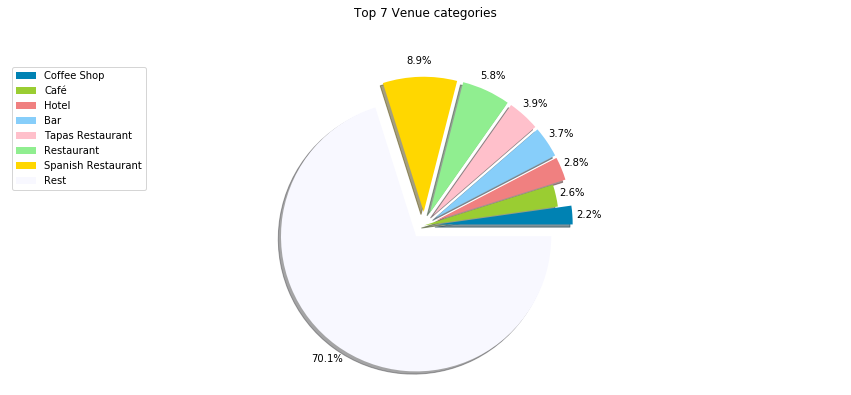

In [134]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', bar_color, 'lightgrey']
colors_list = [font_color, 'yellowgreen', 'lightcoral', 'lightskyblue', 'pink', 'lightgreen', 'gold', 'ghostwhite']
explode_list = [0.1, 0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] 


kVenues = 7
data = madrid_venues_grouped.head(kVenues)   # top venues in Madrid
data = data.sort_values(['Count'], ascending = True)

# Calculate the 'rest'
first_categories = 0
for index, value in enumerate(data['Count']): 
    first_categories = first_categories + value

last_category = madrid_venues['Venue Category'].count() -  first_categories
data = data.append({'Venue Category' :  'Rest', 'Count' : last_category}, ignore_index=True)

data.set_index('Venue Category', inplace = True)  # set category as index
data['Count'].plot(kind='pie',
                   figsize=(15, 6),
                   autopct='%1.1f%%', 
                   startangle=0,    
                   shadow=True,       
                   labels=None,         # turn off labels on pie chart
                   pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                   colors=colors_list,  # add custom colors
                   explode=explode_list # 'explode' lowest 3 continents
                  )

# scale the title up by 12% to match pctdistance
plt.title('Top {:d} Venue categories'.format(kVenues), y=1.12) 
plt.axis('equal') 

plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().axes.get_xaxis().set_visible(True)

# add legend
plt.legend(labels=data.index, loc='upper left') 

plt.show()

#### 5.2 Most repeated words into 'Venu Category' are...
* Spaniard Restaurant, Tapas Restaurant, Mediterranean Restaurant
* Pub ('Bar'), Coffee, Cocktail
* Hotel
* Park, Squares ('Plaza')
Mostly related to leisure time and enjoying life

In [135]:
# I didn't found in Internet the right image to use as a mask :-(
# download image  https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Maps_-_ES_-_Madrid_-_Distritos_-_Municipales2003_preciso.png/220px-Maps_-_ES_-_Madrid_-_Distritos_-_Municipales2003_preciso.png
#!wget --quiet https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Maps_-_ES_-_Madrid_-_Distritos_-_Municipales2003_preciso.png/220px-Maps_-_ES_-_Madrid_-_Distritos_-_Municipales2003_preciso.png  
# save mask to alice_mask
#madrid_mask = np.array(Image.open('220px-Maps_-_ES_-_Madrid_-_Distritos_-_Municipales2003_preciso.png'))

# instantiate a word cloud object
madrid_wc = WordCloud(
    background_color='white', 
    # mask=madrid_mask,
    max_words=2000
)
text = " ".join(category for category in madrid_venues['Venue Category'])

# generate the word cloud
madrid_wc.generate(text)  #, mask=alice_mask

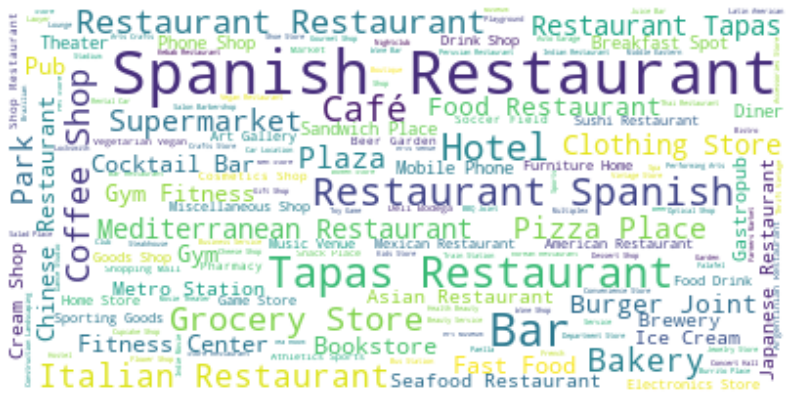

In [136]:
# display the word cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(madrid_wc, interpolation='bilinear')
plt.axis('off')

plt.show()

#### 5.3 There is certain relation between population density of the neighborhood and number of venues around
Though there is a lot of variability:
* It is more frequent to have high number of venues in high population neighborhoods. Lower number of venues only appear at low density neighborhoods, but it is not a linear relation
* Larger neighborhoods could be bad dimensioned at taking only 500 meters around venues, only
* It seems that the **number of venues is usually high**, no matter the population density
* Higher number of venues are in smaller neighborhoods

In [137]:
data = neighborhoods[['Number Venues', 'District density']]
#data = data.drop([43])   # I remove line 43: 'El Pardo'
x = data['District density']
y = data['Number Venues']

In [138]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, color=font_color)

    # now determine nice limits by hand:
    binwidth = 5 #0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth
    bins = np.arange(-lim, lim + binwidth, binwidth)
    
    density_bin = np.arange(0, 300, 30)
    venue_bin = np.arange(0, 100, 10)
    
    ax_histx.hist(x, bins=density_bin, color=bar_color)
    ax_histy.hist(y, bins=venue_bin, orientation='horizontal', color=bar_color)

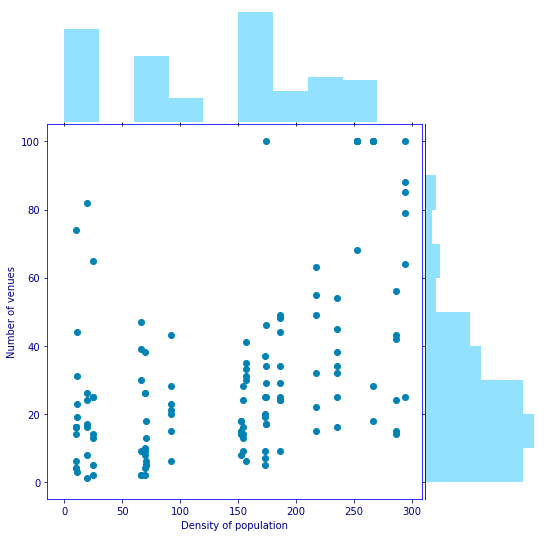

In [139]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(x, y, ax, ax_histx, ax_histy)

#plt.xlabel('Population Density', fontsize=12)
#plt.ylabel('Number of Venues', fontsize=12)
#plt.title('Number of venues vs. Population Density of the neighborhood in Madrid, Spain', fontsize=14)

#for index, value in enumerate(data['Count']): 
#    label = '{:d}'.format(value) # format int with commas
#    plt.annotate(label, xy=(value+4, index), color=font_color, size=12, fontweight='bold')

# Remove frame lines at top, right and left
ax_histx.spines["top"].set_visible(False)
ax_histx.spines["right"].set_visible(False)
ax_histx.spines["left"].set_visible(False)
ax_histx.spines["bottom"].set_visible(False)
ax_histx.get_yaxis().set_ticks([])

ax_histy.spines["top"].set_visible(False)
ax_histy.spines["right"].set_visible(False)
ax_histy.spines["bottom"].set_visible(False)
ax_histy.spines["top"].set_visible(False)
ax_histy.get_xaxis().set_ticks([])

ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)

ax.spines['bottom'].set_color('blue')
ax.spines['top'].set_color('blue') 
ax.spines['right'].set_color('blue')
ax.spines['left'].set_color('blue')
ax.tick_params(axis='x', colors='darkblue')
ax.tick_params(axis='y', colors='darkblue')
ax.yaxis.label.set_color('darkblue')
ax.xaxis.label.set_color('darkblue')
ax.yaxis.label.set_text('Number of venues')
ax.xaxis.label.set_text('Density of population')

plt.show()

**Findings:**
* finally, and attending to density and number of venues, there are thre types of neighborhood:
    * Low density of people and venues: residential areas, in the lower/left area
    * Low people-density but high venue-density areas: residential/urban areas, in the lower/right area of the graphic
    * High density areas of people and venues: urban and touristic areas, in the upper/right area of the chart
* Most of the neighborhoods have a relatively low number of venues: below 50.
* The neighborhoods with more venues usually are more populated, through there are relatively only a few

#### 5.4 Visual analysis of each of the main clusters

There are four main neighborhood clusters in Madrid:
1. Neighborhoods with excellent Spaniard+Tapas gastronomic offer
2. Urban neighborhoods with wider gastronomic offer
3. Residential Neighborhoods with certain gastronomic offer
4. Fully residential neighborhoods

I will be detailing the visual analysis of each cluster from now on:

##### 1st Cluster: Neighborhoods with excellent Spaniard+Tapas gastronomic offer

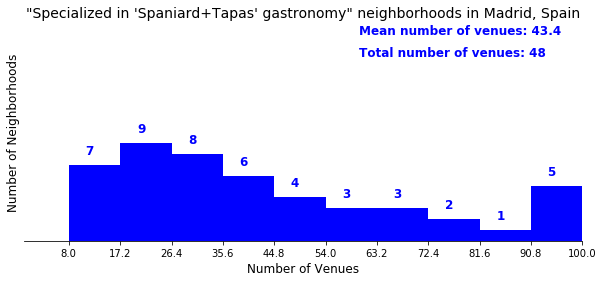

In [62]:
# Number of Cluster - Extremely good local gastronomic offer
cluster_number = 2
cluster_name = "Specialized in 'Spaniard+Tapas' gastronomy"

# Selection of DATA
#cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, :]
cluster = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, :]
cluster_mean = cluster['Number Venues'].mean()
cluster_total = cluster['Neighborhood'].count()
color = webcolors.hex_to_name(rainbow[cluster_number - 1])
cluster_c1 = cluster

# HISTOGRAM
count, bin_edges = np.histogram(cluster['Number Venues'])
cluster['Number Venues'].plot(kind='hist', figsize=(10, 4), xticks=bin_edges, color=color)

plt.title('"{}" neighborhoods in Madrid, Spain'.format(cluster_name), fontsize=14) # add a title to the histogram
plt.ylabel('Number of Neighborhoods', fontsize=12) # add y-label
plt.xlabel('Number of Venues', fontsize=12) # add x-label

for index, value in enumerate(count): 
    label = format(int(value), ',') # format int with commas
    plt.annotate(label, xy=(bin_edges[index]+3, value + 1), color=color, size=12, fontweight='bold')

# Mean number of venues
label = 'Mean number of venues: {:.1f}'.format(cluster_mean)
plt.annotate(label, xy=(60, 19), color=color, size=12, fontweight='bold')
label = 'Total number of venues: {:d}'.format(cluster_total)
plt.annotate(label, xy=(60, 17), color=color, size=12, fontweight='bold')
    
# Remove frame lines at top, right and left
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

# https://www.delftstack.com/howto/matplotlib/how-to-hide-axis-text-ticks-and-or-tick-labels-in-matplotlib/
plt.gca().axes.get_yaxis().set_ticks([])

plt.ylim(ymax = 20) #, ymin = 25)     # Y Axis range
plt.xlim(xmax = 100, xmin = 0)        # X axis range

plt.show()

In [51]:
# Selection of DATA
cluster = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, :]
cluster_neighborhoods = cluster['Neighborhood']

cluster_venues = madrid_venues[madrid_venues['Neighborhood'].isin(cluster_neighborhoods)]

# DATA preparation for word cloud
cluster_wc = WordCloud(
    background_color='white', 
    max_words=2000
)
text = " ".join(category for category in cluster_venues['Venue Category'])
cluster_wc.generate(text)

# DATA preparation for piechart
cluster_venues_grouped = cluster_venues.groupby('Venue Category').count().reset_index()
cluster_venues_grouped.rename(columns={'Neighborhood': 'Count'}, inplace=True)
cluster_venues_grouped.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude'], axis = 1, inplace=True)
cluster_venues_grouped = cluster_venues_grouped.sort_values(['Count'], ascending = False)

print(cluster_venues_grouped.shape)
cluster_venues_grouped.head()

(235, 2)


Venue Category  Count
206  Spanish Restaurant    228
215    Tapas Restaurant    117
14                  Bar     90
186          Restaurant     86
39                 Café     58

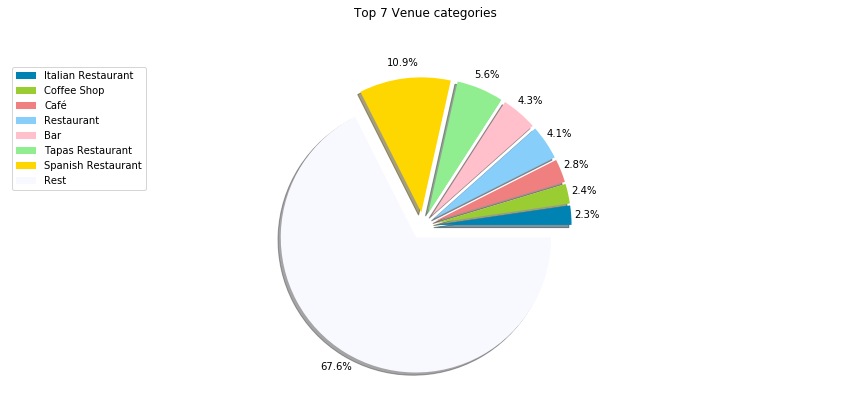

In [52]:
# colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', bar_color, 'lightgrey']
colors_list = [font_color, 'yellowgreen', 'lightcoral', 'lightskyblue', 'pink', 'lightgreen', 'gold', 'ghostwhite']
explode_list = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1] 

kVenues = 7
data = cluster_venues_grouped.head(kVenues)   # top venues in Madrid
data = data.sort_values(['Count'], ascending = True)

# Calculate the 'rest'
first_categories = 0
for index, value in enumerate(data['Count']): 
    first_categories = first_categories + value

last_category = cluster_venues['Venue Category'].count() -  first_categories
data = data.append({'Venue Category' :  'Rest', 'Count' : last_category}, ignore_index=True)

data.set_index('Venue Category', inplace = True)  # set category as index
data['Count'].plot(kind='pie',
                   figsize=(15, 6),
                   autopct='%1.1f%%', 
                   startangle=0,    
                   shadow=True,       
                   labels=None,         # turn off labels on pie chart
                   pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                   colors=colors_list,  # add custom colors
                   explode=explode_list # 'explode' lowest 3 continents
                  )

# scale the title up by 12% to match pctdistance
plt.title('Top {:d} Venue categories'.format(kVenues), y=1.12) 
plt.axis('equal') 

plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().axes.get_xaxis().set_visible(True)

# add legend
plt.legend(labels=data.index, loc='upper left') 

plt.show()


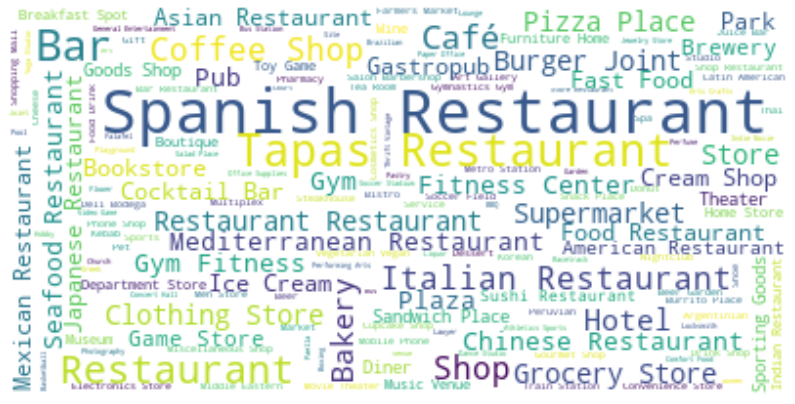

In [53]:
# display the word cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(cluster_wc, interpolation='bilinear')
plt.axis('off')

plt.show()

In [54]:
# create map of clusters:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
for lat, lon, poi, cluster in zip(cluster['Latitude'], cluster['Longitude'], cluster['Neighborhood'], cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster_number), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

##### 2nd Cluster: Urban neighborhoods with wider gastronomic offer

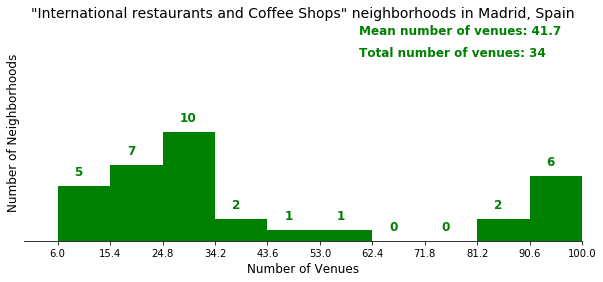

In [61]:
# Number of Cluster - Mid urban/residential neighborhoods
cluster_number = 1
cluster_name = "International restaurants and Coffee Shops"

# Selection of DATA
#cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, :]
cluster = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, :]
cluster_mean = cluster['Number Venues'].mean()
cluster_total = cluster['Neighborhood'].count()
color = webcolors.hex_to_name(rainbow[cluster_number - 1])
cluster_c2 = cluster

# HISTOGRAM
count, bin_edges = np.histogram(cluster['Number Venues'])
cluster['Number Venues'].plot(kind='hist', figsize=(10, 4), xticks=bin_edges, color=color)

plt.title('"{}" neighborhoods in Madrid, Spain'.format(cluster_name), fontsize=14) # add a title to the histogram
plt.ylabel('Number of Neighborhoods', fontsize=12) # add y-label
plt.xlabel('Number of Venues', fontsize=12) # add x-label

for index, value in enumerate(count): 
    label = format(int(value), ',') # format int with commas
    plt.annotate(label, xy=(bin_edges[index]+3, value + 1), color=color, size=12, fontweight='bold')

# Mean number of venues
label = 'Mean number of venues: {:.1f}'.format(cluster_mean)
plt.annotate(label, xy=(60, 19), color=color, size=12, fontweight='bold')
label = 'Total number of venues: {:d}'.format(cluster_total)
plt.annotate(label, xy=(60, 17), color=color, size=12, fontweight='bold')
    
# Remove frame lines at top, right and left
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

# https://www.delftstack.com/howto/matplotlib/how-to-hide-axis-text-ticks-and-or-tick-labels-in-matplotlib/
plt.gca().axes.get_yaxis().set_ticks([])

plt.ylim(ymax = 20) #, ymin = 25)     # Y Axis range
plt.xlim(xmax = 100, xmin = 0)        # X axis range

plt.show()

In [56]:
# Selection of DATA
cluster = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, :]
cluster_neighborhoods = cluster['Neighborhood']

cluster_venues = madrid_venues[madrid_venues['Neighborhood'].isin(cluster_neighborhoods)]

# DATA preparation for word cloud
cluster_wc = WordCloud(
    background_color='white', 
    max_words=2000
)
text = " ".join(category for category in cluster_venues['Venue Category'])
cluster_wc.generate(text)

# DATA preparation for piechart
cluster_venues_grouped = cluster_venues.groupby('Venue Category').count().reset_index()
cluster_venues_grouped.rename(columns={'Neighborhood': 'Count'}, inplace=True)
cluster_venues_grouped.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude'], axis = 1, inplace=True)
cluster_venues_grouped = cluster_venues_grouped.sort_values(['Count'], ascending = False)

print(cluster_venues_grouped.shape)
cluster_venues_grouped.head()

(209, 2)


Venue Category  Count
156          Restaurant    129
180  Spanish Restaurant     93
96                Hotel     72
15                  Bar     41
36                 Café     38

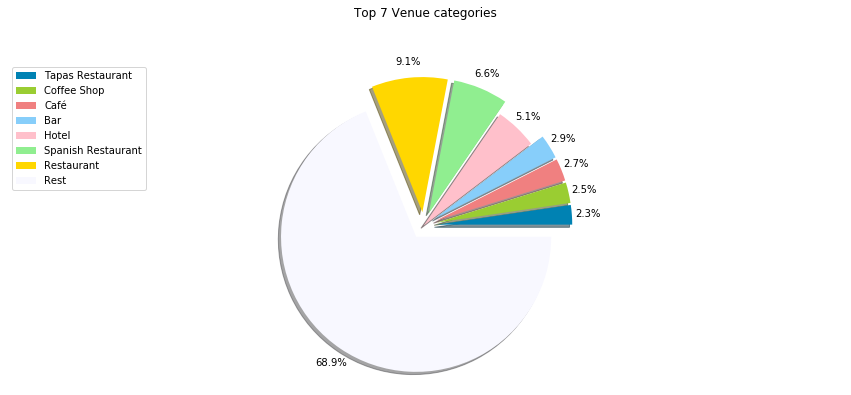

In [57]:
# colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', bar_color, 'lightgrey']
colors_list = [font_color, 'yellowgreen', 'lightcoral', 'lightskyblue', 'pink', 'lightgreen', 'gold', 'ghostwhite']
explode_list = [0.1, 0.1, 0.1, 0.1, 0, 0.1, 0.1, 0.1] 

kVenues = 7
data = cluster_venues_grouped.head(kVenues)   # top venues in Madrid
data = data.sort_values(['Count'], ascending = True)

# Calculate the 'rest'
first_categories = 0
for index, value in enumerate(data['Count']): 
    first_categories = first_categories + value

last_category = cluster_venues['Venue Category'].count() -  first_categories
data = data.append({'Venue Category' :  'Rest', 'Count' : last_category}, ignore_index=True)

data.set_index('Venue Category', inplace = True)  # set category as index
data['Count'].plot(kind='pie',
                   figsize=(15, 6),
                   autopct='%1.1f%%', 
                   startangle=0,    
                   shadow=True,       
                   labels=None,         # turn off labels on pie chart
                   pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                   colors=colors_list,  # add custom colors
                   explode=explode_list # 'explode' lowest 3 continents
                  )

# scale the title up by 12% to match pctdistance
plt.title('Top {:d} Venue categories'.format(kVenues), y=1.12) 
plt.axis('equal') 

plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().axes.get_xaxis().set_visible(True)

# add legend
plt.legend(labels=data.index, loc='upper left') 

plt.show()

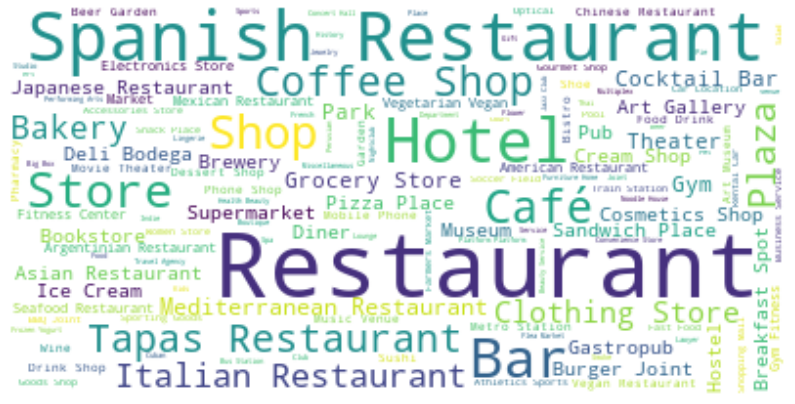

In [58]:
# display the word cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(cluster_wc, interpolation='bilinear')
plt.axis('off')

plt.show()

In [59]:
# create map of clusters:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
for lat, lon, poi, cluster in zip(cluster['Latitude'], cluster['Longitude'], cluster['Neighborhood'], cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster_number), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

##### 3rd Cluster: Residential Neighborhoods with certain gastronomic offer

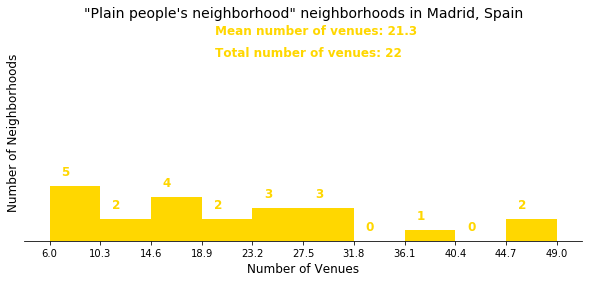

In [75]:
# Number of Cluster - Residential with gastronomic offer
cluster_number = 6
cluster_name = "Plain people's neighborhood"

# Selection of DATA
#cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, :]
cluster = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, :]
cluster_mean = cluster['Number Venues'].mean()
cluster_total = cluster['Neighborhood'].count()
color = webcolors.hex_to_name(rainbow[cluster_number - 1])
cluster_c3 = cluster

# HISTOGRAM
count, bin_edges = np.histogram(cluster['Number Venues'])
cluster['Number Venues'].plot(kind='hist', figsize=(10, 4), xticks=bin_edges, color=color)

plt.title('"{}" neighborhoods in Madrid, Spain'.format(cluster_name), fontsize=14) # add a title to the histogram
plt.ylabel('Number of Neighborhoods', fontsize=12) # add y-label
plt.xlabel('Number of Venues', fontsize=12) # add x-label

for index, value in enumerate(count): 
    label = format(int(value), ',') # format int with commas
    plt.annotate(label, xy=(bin_edges[index]+1, value + 1), color=color, size=12, fontweight='bold')

# Mean number of venues
label = 'Mean number of venues: {:.1f}'.format(cluster_mean)
plt.annotate(label, xy=(20, 19), color=color, size=12, fontweight='bold')
label = 'Total number of venues: {:d}'.format(cluster_total)
plt.annotate(label, xy=(20, 17), color=color, size=12, fontweight='bold')
    
# Remove frame lines at top, right and left
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

# https://www.delftstack.com/howto/matplotlib/how-to-hide-axis-text-ticks-and-or-tick-labels-in-matplotlib/
plt.gca().axes.get_yaxis().set_ticks([])

plt.ylim(ymax = 20) #, ymin = 25)     # Y Axis range
#plt.xlim(xmax = 16, xmin = 5)        # X axis range

plt.show()

In [68]:
# Selection of DATA
cluster = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, :]
cluster_neighborhoods = cluster['Neighborhood']

cluster_venues = madrid_venues[madrid_venues['Neighborhood'].isin(cluster_neighborhoods)]

# DATA preparation for word cloud
cluster_wc = WordCloud(
    background_color='white', 
    max_words=2000
)
text = " ".join(category for category in cluster_venues['Venue Category'])
cluster_wc.generate(text)

# DATA preparation for piechart
cluster_venues_grouped = cluster_venues.groupby('Venue Category').count().reset_index()
cluster_venues_grouped.rename(columns={'Neighborhood': 'Count'}, inplace=True)
cluster_venues_grouped.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude'], axis = 1, inplace=True)
cluster_venues_grouped = cluster_venues_grouped.sort_values(['Count'], ascending = False)

print(cluster_venues_grouped.shape)
cluster_venues_grouped.head()

(118, 2)


Venue Category  Count
55         Grocery Store     33
88           Pizza Place     22
41  Fast Food Restaurant     21
8                    Bar     20
75         Metro Station     16

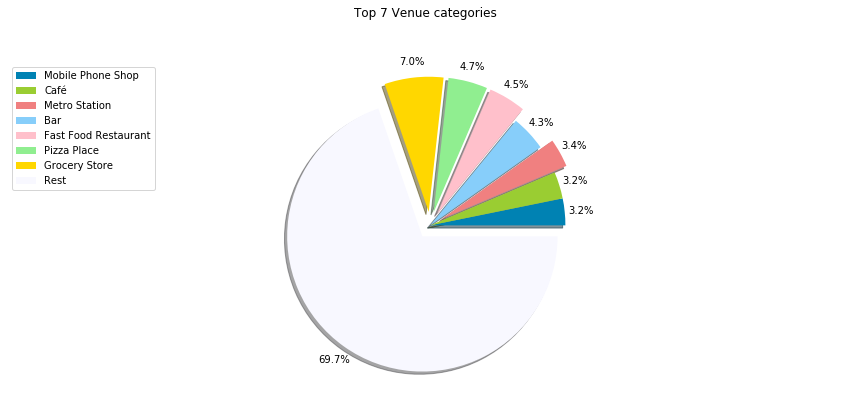

In [69]:
# colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', bar_color, 'lightgrey']
colors_list = [font_color, 'yellowgreen', 'lightcoral', 'lightskyblue', 'pink', 'lightgreen', 'gold', 'ghostwhite']
explode_list = [0, 0, 0.1, 0, 0.1, 0.1, 0.1, 0.1] 

kVenues = 7
data = cluster_venues_grouped.head(kVenues)   # top venues in Madrid
data = data.sort_values(['Count'], ascending = True)

# Calculate the 'rest'
first_categories = 0
for index, value in enumerate(data['Count']): 
    first_categories = first_categories + value

last_category = cluster_venues['Venue Category'].count() -  first_categories
data = data.append({'Venue Category' :  'Rest', 'Count' : last_category}, ignore_index=True)

data.set_index('Venue Category', inplace = True)  # set category as index
data['Count'].plot(kind='pie',
                   figsize=(15, 6),
                   autopct='%1.1f%%', 
                   startangle=0,    
                   shadow=True,       
                   labels=None,         # turn off labels on pie chart
                   pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                   colors=colors_list,  # add custom colors
                   explode=explode_list # 'explode' lowest 3 continents
                  )

# scale the title up by 12% to match pctdistance
plt.title('Top {:d} Venue categories'.format(kVenues), y=1.12) 
plt.axis('equal') 

plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().axes.get_xaxis().set_visible(True)

# add legend
plt.legend(labels=data.index, loc='upper left') 

plt.show()

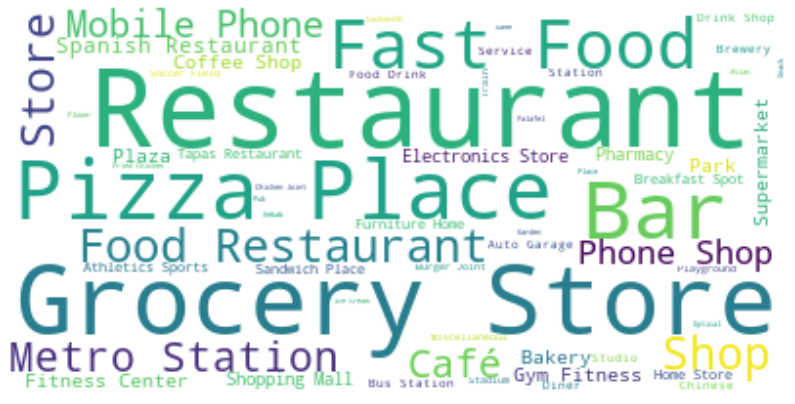

In [70]:
# display the word cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(cluster_wc, interpolation='bilinear')
plt.axis('off')

plt.show()

In [71]:
# create map of clusters:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
for lat, lon, poi, cluster in zip(cluster['Latitude'], cluster['Longitude'], cluster['Neighborhood'], cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster_number), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

##### 4th Cluster: 

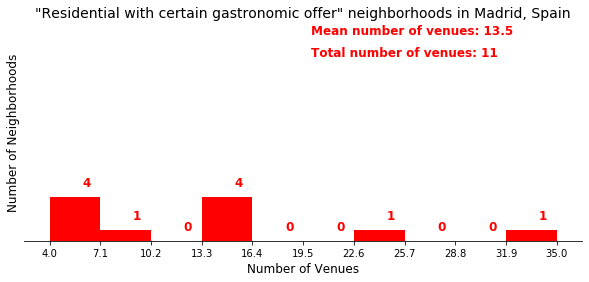

In [78]:
# Number of Cluster - Residential with gastronomic offer
cluster_number = 11
cluster_name = "Residential with certain gastronomic offer"

# Selection of DATA
#cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, :]
cluster = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, :]
cluster_mean = cluster['Number Venues'].mean()
cluster_total = cluster['Neighborhood'].count()
color = webcolors.hex_to_name(rainbow[cluster_number - 1])
cluster_c4 = cluster

# HISTOGRAM
count, bin_edges = np.histogram(cluster['Number Venues'])
cluster['Number Venues'].plot(kind='hist', figsize=(10, 4), xticks=bin_edges, color=color)

plt.title('"{}" neighborhoods in Madrid, Spain'.format(cluster_name), fontsize=14) # add a title to the histogram
plt.ylabel('Number of Neighborhoods', fontsize=12) # add y-label
plt.xlabel('Number of Venues', fontsize=12) # add x-label

for index, value in enumerate(count): 
    label = format(int(value), ',') # format int with commas
    plt.annotate(label, xy=(bin_edges[index]+2, value + 1), color=color, size=12, fontweight='bold')

# Mean number of venues
label = 'Mean number of venues: {:.1f}'.format(cluster_mean)
plt.annotate(label, xy=(20, 19), color=color, size=12, fontweight='bold')
label = 'Total number of venues: {:d}'.format(cluster_total)
plt.annotate(label, xy=(20, 17), color=color, size=12, fontweight='bold')
    
# Remove frame lines at top, right and left
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

# https://www.delftstack.com/howto/matplotlib/how-to-hide-axis-text-ticks-and-or-tick-labels-in-matplotlib/
plt.gca().axes.get_yaxis().set_ticks([])

plt.ylim(ymax = 20) #, ymin = 25)     # Y Axis range
#plt.xlim(xmax = 16, xmin = 5)        # X axis range

plt.show()

In [79]:
# Selection of DATA
cluster = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, :]
cluster_neighborhoods = cluster['Neighborhood']

cluster_venues = madrid_venues[madrid_venues['Neighborhood'].isin(cluster_neighborhoods)]

# DATA preparation for word cloud
cluster_wc = WordCloud(
    background_color='white', 
    max_words=2000
)
text = " ".join(category for category in cluster_venues['Venue Category'])
cluster_wc.generate(text)

# DATA preparation for piechart
cluster_venues_grouped = cluster_venues.groupby('Venue Category').count().reset_index()
cluster_venues_grouped.rename(columns={'Neighborhood': 'Count'}, inplace=True)
cluster_venues_grouped.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude'], axis = 1, inplace=True)
cluster_venues_grouped = cluster_venues_grouped.sort_values(['Count'], ascending = False)

print(cluster_venues_grouped.shape)
cluster_venues_grouped.head()

(62, 2)


Venue Category  Count
56  Spanish Restaurant     36
49          Restaurant     15
5                  Bar      6
60    Tapas Restaurant      5
45                Park      5

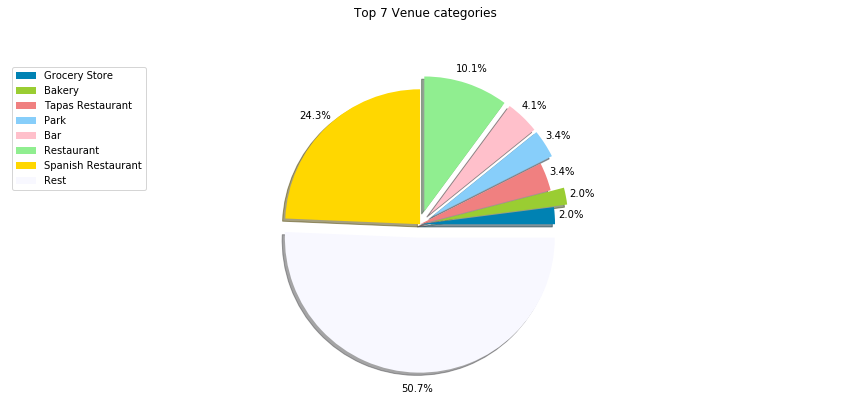

In [80]:
# colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', bar_color, 'lightgrey']
colors_list = [font_color, 'yellowgreen', 'lightcoral', 'lightskyblue', 'pink', 'lightgreen', 'gold', 'ghostwhite']
explode_list = [0, 0.1, 0, 0.1, 0.1, 0.1, 0, 0.1] 

kVenues = 7
data = cluster_venues_grouped.head(kVenues)   # top venues in Madrid
data = data.sort_values(['Count'], ascending = True)

# Calculate the 'rest'
first_categories = 0
for index, value in enumerate(data['Count']): 
    first_categories = first_categories + value

last_category = cluster_venues['Venue Category'].count() -  first_categories
data = data.append({'Venue Category' :  'Rest', 'Count' : last_category}, ignore_index=True)

data.set_index('Venue Category', inplace = True)  # set category as index
data['Count'].plot(kind='pie',
                   figsize=(15, 6),
                   autopct='%1.1f%%', 
                   startangle=0,    
                   shadow=True,       
                   labels=None,         # turn off labels on pie chart
                   pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                   colors=colors_list,  # add custom colors
                   explode=explode_list # 'explode' lowest 3 continents
                  )

# scale the title up by 12% to match pctdistance
plt.title('Top {:d} Venue categories'.format(kVenues), y=1.12) 
plt.axis('equal') 

plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().axes.get_xaxis().set_visible(True)

# add legend
plt.legend(labels=data.index, loc='upper left') 

plt.show()

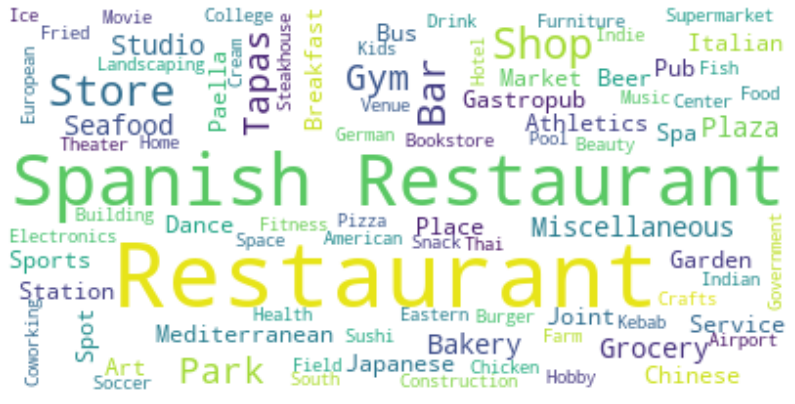

In [81]:
# display the word cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(cluster_wc, interpolation='bilinear')
plt.axis('off')

plt.show()

In [82]:
# create map of clusters:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
for lat, lon, poi, cluster in zip(cluster['Latitude'], cluster['Longitude'], cluster['Neighborhood'], cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster_number), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

##### 5th Cluster: 

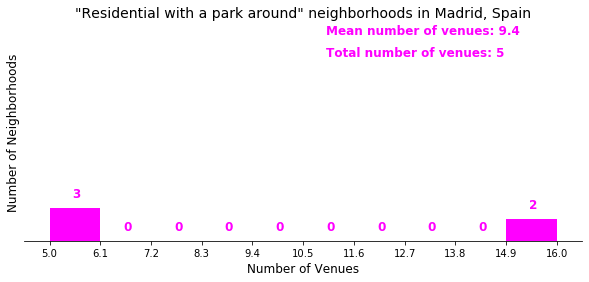

In [88]:
# Number of Cluster - Residential with gastronomic offer
cluster_number = 5
cluster_name = "Residential with a park around"

# Selection of DATA
#cluster = top_venues3.loc[top_venues3['Cluster Labels'] == cluster_number, :]
cluster = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, :]
cluster_mean = cluster['Number Venues'].mean()
cluster_total = cluster['Neighborhood'].count()
color = webcolors.hex_to_name(rainbow[cluster_number - 1])
cluster_c5 = cluster

# HISTOGRAM
count, bin_edges = np.histogram(cluster['Number Venues'])
cluster['Number Venues'].plot(kind='hist', figsize=(10, 4), xticks=bin_edges, color=color)

plt.title('"{}" neighborhoods in Madrid, Spain'.format(cluster_name), fontsize=14) # add a title to the histogram
plt.ylabel('Number of Neighborhoods', fontsize=12) # add y-label
plt.xlabel('Number of Venues', fontsize=12) # add x-label

for index, value in enumerate(count): 
    label = format(int(value), ',') # format int with commas
    plt.annotate(label, xy=(bin_edges[index]+0.5, value + 1), color=color, size=12, fontweight='bold')

# Mean number of venues
label = 'Mean number of venues: {:.1f}'.format(cluster_mean)
plt.annotate(label, xy=(11, 19), color=color, size=12, fontweight='bold')
label = 'Total number of venues: {:d}'.format(cluster_total)
plt.annotate(label, xy=(11, 17), color=color, size=12, fontweight='bold')
    
# Remove frame lines at top, right and left
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

# https://www.delftstack.com/howto/matplotlib/how-to-hide-axis-text-ticks-and-or-tick-labels-in-matplotlib/
plt.gca().axes.get_yaxis().set_ticks([])

plt.ylim(ymax = 20) #, ymin = 25)     # Y Axis range
#plt.xlim(xmax = 16, xmin = 5)        # X axis range

plt.show()

In [84]:
# Selection of DATA
cluster = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, :]
cluster_neighborhoods = cluster['Neighborhood']

cluster_venues = madrid_venues[madrid_venues['Neighborhood'].isin(cluster_neighborhoods)]

# DATA preparation for word cloud
cluster_wc = WordCloud(
    background_color='white', 
    max_words=2000
)
text = " ".join(category for category in cluster_venues['Venue Category'])
cluster_wc.generate(text)

# DATA preparation for piechart
cluster_venues_grouped = cluster_venues.groupby('Venue Category').count().reset_index()
cluster_venues_grouped.rename(columns={'Neighborhood': 'Count'}, inplace=True)
cluster_venues_grouped.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude'], axis = 1, inplace=True)
cluster_venues_grouped = cluster_venues_grouped.sort_values(['Count'], ascending = False)

print(cluster_venues_grouped.shape)
cluster_venues_grouped.head()

(29, 2)


Venue Category  Count
19                        Park     11
21                       Plaza      4
5   Construction & Landscaping      3
0                   Art Museum      2
24                Soccer Field      2

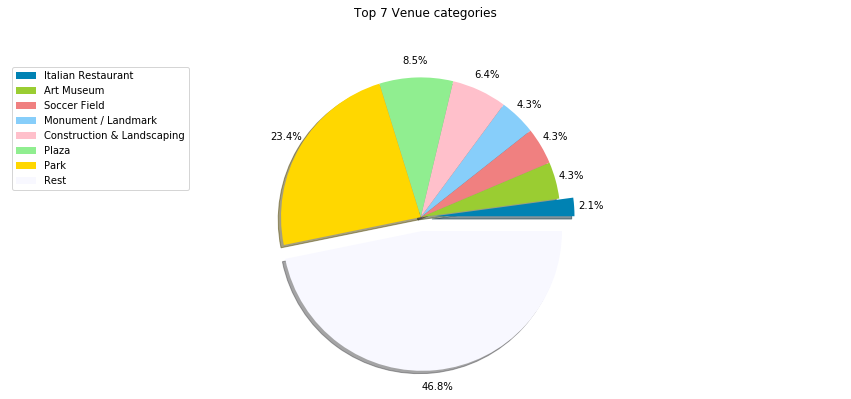

In [89]:
# colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', bar_color, 'lightgrey']
colors_list = [font_color, 'yellowgreen', 'lightcoral', 'lightskyblue', 'pink', 'lightgreen', 'gold', 'ghostwhite']
explode_list = [0.1, 0, 0, 0, 0, 0, 0, 0.1] 

kVenues = 7
data = cluster_venues_grouped.head(kVenues)   # top venues in Madrid
data = data.sort_values(['Count'], ascending = True)

# Calculate the 'rest'
first_categories = 0
for index, value in enumerate(data['Count']): 
    first_categories = first_categories + value

last_category = cluster_venues['Venue Category'].count() -  first_categories
data = data.append({'Venue Category' :  'Rest', 'Count' : last_category}, ignore_index=True)

data.set_index('Venue Category', inplace = True)  # set category as index
data['Count'].plot(kind='pie',
                   figsize=(15, 6),
                   autopct='%1.1f%%', 
                   startangle=0,    
                   shadow=True,       
                   labels=None,         # turn off labels on pie chart
                   pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                   colors=colors_list,  # add custom colors
                   explode=explode_list # 'explode' lowest 3 continents
                  )

# scale the title up by 12% to match pctdistance
plt.title('Top {:d} Venue categories'.format(kVenues), y=1.12) 
plt.axis('equal') 

plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().axes.get_xaxis().set_visible(True)

# add legend
plt.legend(labels=data.index, loc='upper left') 

plt.show()

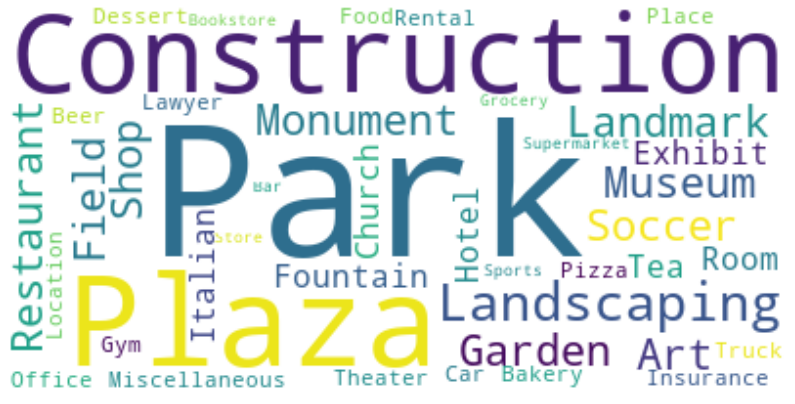

In [90]:
# display the word cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(cluster_wc, interpolation='bilinear')
plt.axis('off')

plt.show()

In [87]:
# create map of clusters:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
for lat, lon, poi, cluster in zip(cluster['Latitude'], cluster['Longitude'], cluster['Neighborhood'], cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster_number), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

##### 6th Cluster: Fully residential Neighborhoods

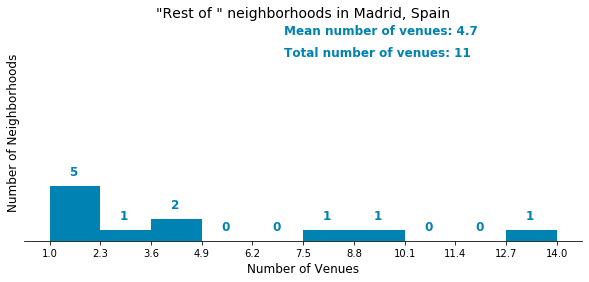

In [120]:
# Number of Cluster - Fully Residential
#cluster_number = 0
cluster_name = "Rest of "

# Selection of DATA
cluster = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == 0, :]
for i in range(15):
    if (i!=0) and (i != 1) and (i != 2) and (i != 5) and (i != 6) and (i != 11):
        cluster2 = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == i, :]
        cluster = cluster.append(cluster2)
        
cluster_mean = cluster['Number Venues'].mean()
cluster_total = cluster['Neighborhood'].count()
color = font_color
cluster_c6 = cluster
#colors_list[5] = color

# HISTOGRAM
count, bin_edges = np.histogram(cluster['Number Venues'])
cluster['Number Venues'].plot(kind='hist', figsize=(10, 4), xticks=bin_edges, color=color)

plt.title('"{}" neighborhoods in Madrid, Spain'.format(cluster_name), fontsize=14) # add a title to the histogram
plt.ylabel('Number of Neighborhoods', fontsize=12) # add y-label
plt.xlabel('Number of Venues', fontsize=12) # add x-label

for index, value in enumerate(count): 
    label = format(int(value), ',') # format int with commas
    plt.annotate(label, xy=(bin_edges[index]+0.5, value+1), color=color, size=12, fontweight='bold')

# Mean number of venues
label = 'Mean number of venues: {:.1f}'.format(cluster_mean)
plt.annotate(label, xy=(7, 19), color=color, size=12, fontweight='bold')
label = 'Total number of venues: {:d}'.format(cluster_total)
plt.annotate(label, xy=(7, 17), color=color, size=12, fontweight='bold')
    
# Remove frame lines at top, right and left
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

# https://www.delftstack.com/howto/matplotlib/how-to-hide-axis-text-ticks-and-or-tick-labels-in-matplotlib/
plt.gca().axes.get_yaxis().set_ticks([])

plt.ylim(ymax = 20) #, ymin = 25)     # Y Axis range
#plt.xlim(xmax = 16, xmin = 1)        # X axis range

plt.show()

In [112]:
# Selection of DATA
cluster = neighborhoods_clustered3.loc[neighborhoods_clustered3['Cluster Labels'] == cluster_number, :]
cluster_neighborhoods = cluster['Neighborhood']

cluster_venues = madrid_venues[madrid_venues['Neighborhood'].isin(cluster_neighborhoods)]

# DATA preparation for word cloud
cluster_wc = WordCloud(
    background_color='white', 
    max_words=2000
)
text = " ".join(category for category in cluster_venues['Venue Category'])
cluster_wc.generate(text)

# DATA preparation for piechart
cluster_venues_grouped = cluster_venues.groupby('Venue Category').count().reset_index()
cluster_venues_grouped.rename(columns={'Neighborhood': 'Count'}, inplace=True)
cluster_venues_grouped.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude'], axis = 1, inplace=True)
cluster_venues_grouped = cluster_venues_grouped.sort_values(['Count'], ascending = False)

print(cluster_venues_grouped.shape)
cluster_venues_grouped.head()

(29, 2)


Venue Category  Count
19                        Park     11
21                       Plaza      4
5   Construction & Landscaping      3
0                   Art Museum      2
24                Soccer Field      2

In [119]:
cluster_c6

Cluster Labels  District Code             District  District Surface  \
81                0             13   Puente de Vallecas           1496.86   
117               3             19            Vicálvaro           3526.67   
51                4              9      Moncloa-Aravaca           4653.11   
101               7             16            Hortaleza           2741.98   
105               8             16            Hortaleza           2741.98   
129               9             21              Barajas           4192.28   
45               10              8  Fuencarral-El Pardo          23783.84   
122              12             20  San Blas-Canillejas           2229.24   
50               13              8  Fuencarral-El Pardo          23783.84   
118              14             20  San Blas-Canillejas           2229.24   
120              14             20  San Blas-Canillejas           2229.24   

     District Population  District density     Neighborhood  \
81              227595.0            152.05  Palomeras Bajas   
117              70051.0             19.86     El Cañaveral   
51              116903.0             25.12    Casa de Campo   
101             180462.0             65.81          Piovera   
105             180462.0             65.81     Valdefuentes   
129              46876.0             11.18            Timón   
45              238756.0             10.04       Peñagrande   
122             154357.0             69.24            Rosas   
50              238756.0             10.04        El Goloso   
118             154357.0             69.24         Simancas   
120             154357.0             69.24          Amposta   

     Neighborhood Code  Neighborhood Surface   Latitude  Longitude  \
81                 133                 1.724  40.385180  -3.658487   
117                194                 9.388  40.392880  -3.569756   
51                  91                17.470  40.424068  -3.755858   
101                162                 3.139  40.455569  -3.636582   
105                166                16.778  40.490520  -3.638321   
129                214                 9.595  40.485680  -3.604720   
45                  83                 2.890  40.477913  -3.727678   
122                205                 9.388  40.428713  -3.593758   
50                  88                26.509  40.557883  -3.714013   
118                201                 2.278  40.427555  -3.622991   
120                203                 0.370  40.425973  -3.622273   

     Number Venues  Percentage Venues  ATM  Accessories Store  Adult Boutique  \
81            14.0           0.003318  0.0                0.0             0.0   
117            1.0           0.000237  0.0                0.0             0.0   
51             2.0           0.000474  0.0                0.0             0.0   
101            2.0           0.000474  0.0                0.0             0.0   
105            2.0           0.000474  0.0                0.0             0.0   
129            3.0           0.000711  0.0                0.0             0.0   
45             4.0           0.000948  0.0                0.0             0.0   
122            2.0           0.000474  0.0                0.0             0.0   
50             4.0           0.000948  0.0                0.0             0.0   
118            8.0           0.001896  0.0                0.0             0.0   
120           10.0           0.002370  0.0                0.0             0.0   

     Advertising Agency  Airport  American Restaurant  Arepa Restaurant  \
81             0.071429      0.0                  0.0               0.0   
117            0.000000      0.0                  0.0               0.0   
51             0.000000      0.0                  0.0               0.0   
101            0.000000      0.0                  0.0               0.0   
105            0.000000      0.0                  0.0               0.0   
129            0.000000      0.0                  0.0      

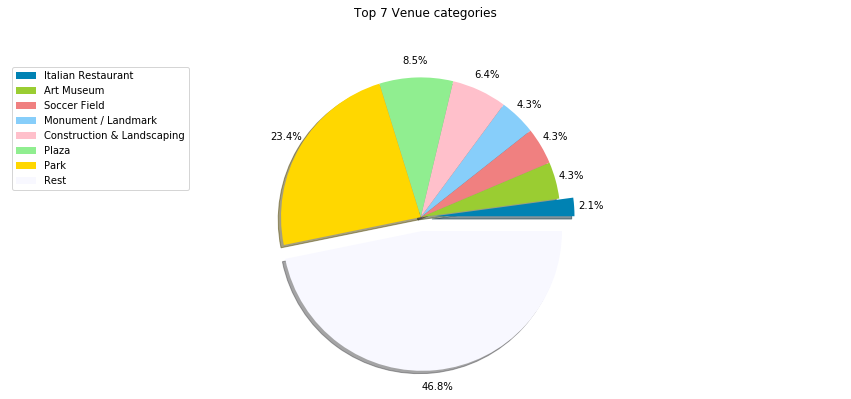

In [113]:
# colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', bar_color, 'lightgrey']
colors_list = [font_color, 'yellowgreen', 'lightcoral', 'lightskyblue', 'pink', 'lightgreen', 'gold', 'ghostwhite']
explode_list = [0.1, 0, 0, 0, 0, 0, 0, 0.1] 

kVenues = 7
data = cluster_venues_grouped.head(kVenues)   # top venues in Madrid
data = data.sort_values(['Count'], ascending = True)

# Calculate the 'rest'
first_categories = 0
for index, value in enumerate(data['Count']): 
    first_categories = first_categories + value

last_category = cluster_venues['Venue Category'].count() -  first_categories
data = data.append({'Venue Category' :  'Rest', 'Count' : last_category}, ignore_index=True)

data.set_index('Venue Category', inplace = True)  # set category as index
data['Count'].plot(kind='pie',
                   figsize=(15, 6),
                   autopct='%1.1f%%', 
                   startangle=0,    
                   shadow=True,       
                   labels=None,         # turn off labels on pie chart
                   pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                   colors=colors_list,  # add custom colors
                   explode=explode_list # 'explode' lowest 3 continents
                  )

# scale the title up by 12% to match pctdistance
plt.title('Top {:d} Venue categories'.format(kVenues), y=1.12) 
plt.axis('equal') 

plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().axes.get_xaxis().set_visible(True)

# add legend
plt.legend(labels=data.index, loc='upper left') 

plt.show()

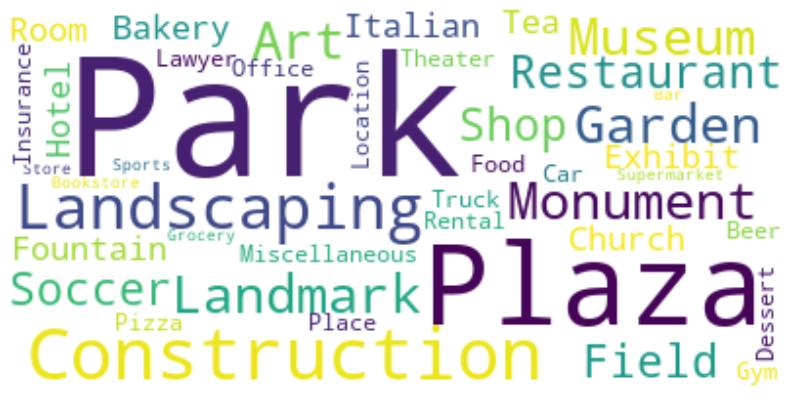

In [114]:
# display the word cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(cluster_wc, interpolation='bilinear')
plt.axis('off')

plt.show()

In [117]:
# create map of clusters:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
for lat, lon, poi, cluster in zip(cluster['Latitude'], cluster['Longitude'], cluster['Neighborhood'], cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster_number), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

**As it can be seen in the word maps:**
* Buzz-words are mostly the same in every cluster
* 'Restaurant' is the most repeated word
* Definitely, Madrid is a place to enjoy gastronomy and friends...

------------------------------------------

## 6. Conclussions<a name="conclusion"></a>

When coming to characterize the neighborhoods in Madrid, I have reached to two main criteria:
* Population density
* Gastronomic offer

**Population density**: There is a lot of variety amongst the neighborhoods of Madrid, when we talk of population density, so it can be a good decision parameter:
* From the **most populated neighborhoods, in the core of the city** (Salamanca, Tetuán, chamberí). The more centric and populated the neighborhood the more venues it uses to have. Than neighborhoods have a more urban profile, with more entertainment possibilities
* To the **neighborhoods that are situated far from the core**, which are much less populated (El Pardo, Aravaca, Villa de Vallecas, Barajas). In this case, you can also chose between the more touristic ones (El Pardo, with its old city, restaurants and parks) and the most residential ones (Vallecas, Barajas)

The number of venues is only related to people density in high populated neighborhoods (high population calls for high venue density). In low populated neighborhoods, venue-density depends on the character of the neighborhood, if it is more or less touristic (old cities, parks, soccer Stadiums) or more residential.

**Gastronomic offer:**
Madrid is a very social and welcoming city, with many options for cultural and entertainment tourism, and lots of places and opportunities to share life with your loved ones. So, the most frequent venues you can find in the city are: 1) Spaniard, 'Tapas' and other-kind-of restaurants (Italian, Asian, fast-food, etc.), 2) pubs, coffee shops and 'beer gardens', 3) Public parks, large squares and places to have a walk... in addition to every other kind of venues: 4) gyms, supermarkets, museums, art galleries, theaters, spas, the Royal Palace...

But most of all, **the kind of gastronomic offer is one of the main drivers of the neighborhood clusterization**. All in all, the gastronomy, due to their quality and variety, in addition to its social dimension, is really important in Spain.

No matter how many clusters you intend to find, the outcome is always mostly the same, and always mostly related to the short of gastronomy you can find around. 

**The main clusters found are:**
1. **Neighborhoods with lots of Traditional food (Spaniard and Tapas) venues, in addition to other wide range of possibilities (mean number of venues: 43)**. These are the most touristic areas, in the center of Madrid, with more entertainment opportunities for young people or couples without children. Tough there also are neighborhoods with less venues.
2. **Neighborhoods where it is easier to find other kind of restaurants (in addition to the traditional ones): Italian, American, Asian, etc.)**. There is still a good entertainment offer, though lower than in the first cluster (avg number of venues: 32). These neighborhoods are more in the outskirts of the city core. They are between pure residential and pure urban areas, but still with a good entertainment offer around food, museums, theaters, parks, etc.
3. **Residential neighborhoods with a good local (Spaniard + Tapas) gastronomic offer**, but not much more... a supermaket, a pharmacy and a gym. Avg number of venues: 32, but mainly restaurants and pubs.
4. **Fully residential neighborhoods** with a really low number of venues (below 5), the type, depending on the place

**FINAL CONCLUSION:**<BR><BR>
**Under the light of the analyzed information, **the neighborhoods in Madrid are very homogeneous** in venues and infrastructure. Every neighborhood (except for those that are more residential) have relatively at hand any kind of infrastructure and resources, or people can reach to every short of venue easily on the public transport.

**The main decision for people looking for a new house is really if they want to live in a 1) more centric/urban/touristic neighborhood** (also with more venues around), **or 2) if they prefer a more residential place** where there are mostly houses, **or maybe 3) if they want to life in low people-density place... with some gradient in between**. This is very close to the current reality in Madrid, indeed.

For me, it has been **very interesting to discover how data can provide so easily a scientific support to the idea that people is currently having in mind** in Madrid when looking for a house... and thereafter, in so many other aspects of life. I have really enjoyed the experience. **I would like to thank IBM and the teachers for the opportunity of doing this certificate**.

-------------

**FURTHER STEPS**:<BR><BR>
More KPIs could be analyzed to have a better clusterization of the neighborhoods in Madrid. Good KPIs (in addition to people density and kind/number of venues analyzed here) could be: average price of houses in the neighborhood, social, education and criminality levels of each neighborhood.

The results could arise new and interesting knowledge of the city.

-------------------------------------------------------

-------------------------
<BR><BR><BR><BR><BR><BR><BR><BR>
(Auxiliary cells for working)

# SAVE FILES

In [34]:
madrid_grouped.to_csv('madrid_grouped.csv')

In [35]:
neighborhoods_venues_sorted.to_csv('madrid_neighborhoods_venues_sorted.csv')

In [36]:
neighborhoods.to_csv('madrid_neighborhoods.csv')

# LOAD FILES

In [2]:
# Execute always you need to reload FourSquare data
madrid_grouped = pd.read_csv('madrid_grouped.csv')
madrid_grouped.drop('Unnamed: 0', axis=1, inplace=True)
print(madrid_grouped.shape)
madrid_grouped.head()

(131, 304)


Neighborhood  ATM  Accessories Store  Adult Boutique  \
0          Abrantes  0.0                0.0             0.0   
1           Acacias  0.0                0.0             0.0   
2           Adelfas  0.0                0.0             0.0   
3        Aeropuerto  0.0                0.0             0.0   
4  Alameda de Osuna  0.0                0.0             0.0   

   Advertising Agency  Airport  American Restaurant  Arepa Restaurant  \
0                 0.0      0.0                  0.0               0.0   
1                 0.0      0.0                  0.0               0.0   
2                 0.0      0.0                  0.0               0.0   
3                 0.0      0.0                  0.0               0.0   
4                 0.0      0.0                  0.0               0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Art Studio  \
0                     0.0     0.000000         0.0         0.0   
1                     0.0     0.066667         0.0         0.0   
2                     0.0     0.000000         0.0         0.0   
3                     0.0     0.000000         0.0         0.0   
4                     0.0     0.000000         0.0         0.0   

   Arts & Crafts Store  Asian Restaurant  Astrologer  Athletics & Sports  \
0                  0.0          0.000000    0.058824            0.058824   
1                  0.0          0.022222    0.000000            0.000000   
2                  0.0          0.020408    0.000000            0.000000   
3                  0.0          0.000000    0.000000            0.000000   
4                  0.0          0.000000    0.000000            0.000000   

   Auto Dealership  Auto Garage  BBQ Joint  Baby Store  Bagel Shop    Bakery  \
0              0.0          0.0        0.0         0.0         0.0  0.117647   
1              0.0          0.0        0.0         0.0         0.0  0.022222   
2              0.0          0.0        0.0         0.0         0.0  0.020408   
3              0.0          0.0        0.0         0.0         0.0  0.000000   
4              0.0          0.0        0.0         0.0         0.0  0.064516   

   Bank       Bar  Basketball Court  Basketball Stadium  Bed & Breakfast  \
0   0.0  0.000000               0.0                 0.0              0.0   
1   0.0  0.111111               0.0                 0.0              0.0   
2   0.0  0.061224               0.0                 0.0              0.0   
3   0.0  0.000000               0.0                 0.0              0.0   
4   0.0  0.032258               0.0                 0.0              0.0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bistro  Board Shop  \
0       0.0          0.0         0.0            0.0     0.0         0.0   
1       0.0          0.0         0.0            0.0     0.0         0.0   
2       0.0          0.0         0.0            0.0     0.0         0.0   
3       0.0          0.0         0.0            0.0     0.0         0.0   
4       0.0          0.0         0.0            0.0     0.0         0.0   

   Boat or Ferry  Bookstore  Boutique  Bowling Alley  Boxing Gym  \
0            0.0   0.000000       0.0            0.0         0.0   
1            0.0   0.066667       0.0            0.0         0.0   
2            0.0   0.020408       0.0            0.0         0.0   
3            0.0   0.000000       0.0            0.0         0.0   
4            0.0   0.032258       0.0            0.0         0.0   

   Brazilian Restaurant  Breakfast Spot   Brewery  Buffet  Building  \
0                   0.0        0.000000  0.000000     0.0       0.0   
1                   0.0        0.000000  0.000000     0.0       0.0   
2                   0.0        0.020408  0.020408     0.0       0.0   
3                   0.0        0.043478  0.000000     0.0       0.0   
4                   0.0        0.032258  0.000000     0.0       0.0   

   Burger Joint  Burrito Place  Bus Line  Bus Station  Bus Stop  \
0           0.0            0.0       0.0   

In [3]:
# Execute always you need to reload FourSquare data
neighborhoods_venues_sorted = pd.read_csv('madrid_neighborhoods_venues_sorted.csv')
neighborhoods_venues_sorted.drop('Unnamed: 0', axis=1, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(131, 12)


Neighborhood  Percentage Venues 1st Most Common Venue 2nd Most Common Venue  \
0      Palacio           0.016118      Tapas Restaurant                 Plaza   
1  Embajadores           0.023702                   Bar      Tapas Restaurant   
2       Cortes           0.023702    Spanish Restaurant                 Hotel   
3     Justicia           0.023702    Spanish Restaurant            Restaurant   
4  Universidad           0.023702                   Bar      Tapas Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0    Spanish Restaurant                   Bar            Restaurant   
1                Hostel               Theater                  Café   
2            Restaurant                 Plaza               Theater   
3                Bakery                 Hotel             Gastropub   
4          Cocktail Bar             Bookstore                 Plaza   

  6th Most Common Venue          7th Most Common Venue 8th Most Common Venue  \
0          Cocktail Bar             Mexican Restaurant             Gastropub   
1           Pizza Place                    Coffee Shop                 Hotel   
2                   Bar       Mediterranean Restaurant    Seafood Restaurant   
3         Deli / Bodega  Vegetarian / Vegan Restaurant           Flower Shop   
4    Spanish Restaurant                     Restaurant                  Café   

           9th Most Common Venue    10th Most Common Venue  
0                       Beer Bar         Korean Restaurant  
1                     Restaurant  Mediterranean Restaurant  
2                 Breakfast Spot          Sushi Restaurant  
3             Italian Restaurant            Sandwich Place  
4  Vegetarian / Vegan Restaurant            Breakfast Spot

In [4]:
# Execute always you need to reload FourSquare data
neighborhoods = pd.read_csv('madrid_neighborhoods.csv')
neighborhoods.drop('Unnamed: 0', axis=1, inplace=True)
print(neighborhoods.shape)
neighborhoods.head()

(131, 315)


District Code District  District Surface  District Population  \
0              1   Centro            522.82             131928.0   
1              1   Centro            522.82             131928.0   
2              1   Centro            522.82             131928.0   
3              1   Centro            522.82             131928.0   
4              1   Centro            522.82             131928.0   

   District density Neighborhood  Neighborhood Code  Neighborhood Surface  \
0            252.34      Palacio                 11                 1.471   
1            252.34  Embajadores                 12                 1.032   
2            252.34       Cortes                 13                 0.592   
3            252.34     Justicia                 14                 0.742   
4            252.34  Universidad                 15                 0.947   

    Latitude  Longitude  Number Venues  Percentage Venues  ATM  \
0  40.415129  -3.715618           68.0           0.016118  0.0   
1  40.409681  -3.701644          100.0           0.023702  0.0   
2  40.414779  -3.697584          100.0           0.023702  0.0   
3  40.423957  -3.695747          100.0           0.023702  0.0   
4  40.425409  -3.705989          100.0           0.023702  0.0   

   Accessories Store  Adult Boutique  Advertising Agency  Airport  \
0               0.00            0.00                 0.0      0.0   
1               0.00            0.00                 0.0      0.0   
2               0.00            0.00                 0.0      0.0   
3               0.01            0.01                 0.0      0.0   
4               0.00            0.00                 0.0      0.0   

   American Restaurant  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0                 0.00               0.0                0.014706         0.00   
1                 0.00               0.0                0.010000         0.03   
2                 0.00               0.0                0.010000         0.01   
3                 0.03               0.0                0.010000         0.01   
4                 0.00               0.0                0.020000         0.01   

   Art Museum  Art Studio  Arts & Crafts Store  Asian Restaurant  Astrologer  \
0        0.00         0.0                 0.00              0.00         0.0   
1        0.00         0.0                 0.00              0.00         0.0   
2        0.01         0.0                 0.00              0.01         0.0   
3        0.01         0.0                 0.01              0.00         0.0   
4        0.00         0.0                 0.01              0.00         0.0   

   Athletics & Sports  Auto Dealership  Auto Garage  BBQ Joint  Baby Store  \
0                 0.0              0.0          0.0       0.00         0.0   
1                 0.0              0.0          0.0       0.00         0.0   
2                 0.0              0.0          0.0       0.00         0.0   
3                 0.0              0.0          0.0       0.01         0.0   
4                 0.0              0.0          0.0       0.00         0.0   

   Bagel Shop    Bakery  Bank       Bar  Basketball Court  Basketball Stadium  \
0         0.0  0.014706   0.0  0.073529               0.0                 0.0   
1         0.0  0.000000   0.0  0.120000               0.0                 0.0   
2         0.0  0.000000   0.0  0.030000               0.0                 0.0   
3         0.0  0.060000   0.0  0.000000               0.0                 0.0   
4         0.0  0.000000   0.0  0.070000               0.0                 0.0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0              0.0  0.029412         0.00        0.00            0.0   
1              0.0  0.000000         0.01        0.00            0.0   
2              0.0  0.010000         0.00        0.00            0.0   
3              0.0  0.000000         0.01        0.01            0.0   
4              0.0  0.010000       

In [5]:
# Execute always you need to reload FourSquare data
madrid_venues = pd.read_csv('madrid_venues.csv')
madrid_venues.drop('Unnamed: 0', axis=1, inplace=True)
print(madrid_venues.shape)
madrid_venues.head()

(4219, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0      Palacio              40.415129               -3.715618   
1      Palacio              40.415129               -3.715618   
2      Palacio              40.415129               -3.715618   
3      Palacio              40.415129               -3.715618   
4      Palacio              40.415129               -3.715618   

                                             Venue  Venue Latitude  \
0     Almudena Cathedral (Catedral de la Almudena)       40.415767   
1                             Plaza de La Almudena       40.416320   
2                              Cervecería La Mayor       40.415218   
3                                  Taberna Rayuela       40.413179   
4  Royal Palace of Madrid (Palacio Real de Madrid)       40.417940   

   Venue Longitude    Venue Category  
0        -3.714516            Church  
1        -3.713777             Plaza  
2        -3.712194          Beer Bar  
3        -3.713496  Tapas Restaurant  
4        -3.714259            Palace